# Data Understanding 1st Iteration

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import scipy.stats as stats
import itertools
from tqdm import tqdm
import pandas as pd

## Functions

### Loading images 

In [5]:
def load_images_from_folder(folder_path, extensions=('.png', '.jpg', '.jpeg', '.JPG')):
    """
    Load all image file paths from a specified folder that match the given file extensions.

    Parameters:
    folder_path (str): The path to the folder containing the images.
    extensions (tuple of str): A tuple of file extensions to filter the images by. 
                               Default is ('.png', '.jpg', '.jpeg', '.JPG').

    Returns:
    list: A list of full file paths to images in the folder that match the specified extensions.
    
    Raises:
    FileNotFoundError: If the specified folder does not exist.
    """

    # Check if the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The specified folder does not exist: {folder_path}")

    # List comprehension to gather all image paths with the specified extensions
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(extensions)]

    return image_paths

In [6]:
def load_and_preprocess_images(image_paths, resize_dim=(256, 256)):
    images = []

    # Initialize tqdm progress bar
    for path in tqdm(image_paths, desc="Loading and preprocessing images", unit="image"):
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img_resized = cv2.resize(img_gray, resize_dim)  # Resize for consistency
        images.append(img_resized)

    return images

### Statistical Analysis

Functions to calculate the brightness, sharpness and contrast of the images

In [7]:
def calculate_brightness(image):
    return np.mean(image)  # Mean pixel intensity

In [8]:
def calculate_sharpness(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()  # Variance of Laplacian method

In [9]:
def calculate_contrast(image):
    return image.std()  # Standard deviation of pixel values

In [10]:
def calculate_noise(image):
    # Calculate the variance of the Laplacian, lower values indicate less noise
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [11]:
def calculate_skew(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")

    # Apply thresholding to get a binary image
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the binary image
    coords = np.column_stack(np.where(binary > 0))

    if coords.size == 0:  # Check if there are any coordinates found
        return 0  # If no contours found, return 0 as skew

    angle = cv2.minAreaRect(coords)[-1]

    # Adjust angle
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    return angle

In [12]:
def calculate_line_spacing(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours to get bounding boxes of text lines
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    heights = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        heights.append(h)

    # Calculate average spacing based on the heights of bounding boxes
    if len(heights) > 1:
        line_spacing = np.mean(np.diff(sorted(heights)))
    else:
        line_spacing = 0  # No lines found

    return line_spacing

In [13]:
def detect_tables(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)
    
    binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours that could represent tables
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    table_contours = []

    for contour in contours:
        # Filter contours by area to identify potential tables
        if cv2.contourArea(contour) > 1000:  # Threshold for minimum area
            table_contours.append(contour)

    return len(table_contours)  # Return the number of detected tables


In [14]:
# Function to calculate image resolution
def calculate_resolution(image):
    height, width = image.shape[:2]  # Get dimensions of the image
    return height * width  # Return the total number of pixels

In [15]:
# Function to calculate text and table alignment (simple heuristic)
def calculate_text_table_alignment(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours to identify the alignment of tables and text
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate the alignment based on the bounding box of the contours
    alignments = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        alignments.append((x, y, w, h))

    # Here, you can develop a more sophisticated measure for alignment if needed
    return len(alignments)  # Return number of detected bounding boxes as a simple measure

In [16]:
# Function to calculate table structure complexity
def calculate_table_structure_complexity(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours to identify table structures
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Count the number of contours (tables) as a simple measure of complexity
    return len(contours)


In [17]:
# Function to calculate image texture (using standard deviation of pixel values)
def calculate_texture(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    return image.std()  # Standard deviation as a measure of texture complexity


In [18]:
# Function to calculate patterns (simple edge detection to find patterns)
def calculate_patterns(image):
    # Check if the image is 2D (grayscale)
    if len(image.shape) != 2:
        raise ValueError("Invalid image format. Image must be a 2D grayscale image.")
    edges = cv2.Canny(image, 100, 200)  # Edge detection
    return np.sum(edges > 0)  # Count the number of edge pixels as a measure of patterns

### Statistical Summary

This function provides summary statistics for all images based on brightness, sharpness, and contrast.

In [19]:
def image_statistics_table(images):
    stats_data = {'Image': [], 
                  'Brightness': [], 
                  'Sharpness': [], 
                  'Contrast': [],
                  'Noise': [],
                  'Skew': [],
                  'Line Spacing': [],
                  'Tables Detected': [],
                  'Resolution': [],
                  'Text and Table Alignment': [],
                  'Table Structure Complexity': [],
                  'Texture': [],
                  'Patterns': []}

    for i, img in enumerate(images):
        stats_data['Image'].append(f'Image_{i+1}')
        stats_data['Brightness'].append(calculate_brightness(img))
        stats_data['Sharpness'].append(calculate_sharpness(img))
        stats_data['Contrast'].append(calculate_contrast(img))
        stats_data['Noise'].append(calculate_noise(img))
        stats_data['Skew'].append(calculate_skew(img))
        stats_data['Line Spacing'].append(calculate_line_spacing(img))
        stats_data['Tables Detected'].append(detect_tables(img))
        stats_data['Resolution'].append(calculate_resolution(img))
        stats_data['Text and Table Alignment'].append(calculate_text_table_alignment(img))
        stats_data['Table Structure Complexity'].append(calculate_table_structure_complexity(img))
        stats_data['Texture'].append(calculate_texture(img))
        stats_data['Patterns'].append(calculate_patterns(img))
    # Create a DataFrame to store per-image statistics
    df = pd.DataFrame(stats_data)
    return df

In [20]:
# Function to calculate overall statistical summary as a table
def overall_statistical_summary(df):
    # Calculate the summary for Brightness, Sharpness, and Contrast
    summary_df = df[['Brightness', 'Sharpness', 'Contrast','Noise','Skew','Line Spacing', 'Tables Detected','Resolution',
                 'Text and Table Alignment','Table Structure Complexity','Texture','Patterns']].describe()

    # Return the summary table
    return summary_df

### Visualizations

#### General functions

In [21]:
# Function for visualizing histograms and other distributions
def plot_characteristic_distribution(df, characteristic, unit, plot_type='hist'):
    plt.figure(figsize=(10, 6))

    if plot_type == 'hist':
        sns.histplot(df[characteristic], kde=True, bins=30, color='blue')
    elif plot_type == 'box':
        sns.boxplot(x=df[characteristic], color='green')
    elif plot_type == 'violin':
        sns.violinplot(x=df[characteristic], color='orange')

    plt.title(f"Distribution of {characteristic}")
    plt.xlabel(f"{characteristic} ({unit})")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

#### Relationships

In [22]:
# Function to plot relationships (scatter plots) between two characteristics
def plot_characteristic_relationship(df, characteristic_1, characteristic_2, unit_1, unit_2, use_color=False):
    plt.figure(figsize=(10, 6))

    if use_color:
        sns.scatterplot(x=df[characteristic_1], y=df[characteristic_2], hue=df[characteristic_2], palette='coolwarm', s=50)
    else:
        sns.scatterplot(x=df[characteristic_1], y=df[characteristic_2], s=50)

    plt.title(f"Relationship between {characteristic_1} and {characteristic_2}")
    plt.xlabel(f"{characteristic_1} ({unit_1})")
    plt.ylabel(f"{characteristic_2} ({unit_2})")
    plt.grid(True)
    plt.show()


In [23]:
# Function to create a heatmap for correlations between characteristics
def plot_correlation_heatmap(df, characteristics, characteristic_units):
    plt.figure(figsize=(10, 8))  # Increase figure size for better visibility
    correlation_matrix = df[characteristics].corr()

    # Create annotations with correlation values and units
    annot = correlation_matrix.round(2).astype(str)  # Round and convert to string
    for i in range(len(characteristics)):
        for j in range(len(characteristics)):
            annot.iloc[i, j] += f"\n({characteristic_units[j]})"  # Append units

    # Create the heatmap
    sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', linewidths=0.5, fmt='',
                cbar_kws={'shrink': 0.8}, annot_kws={"size": 10})  # Font size for annotations

    plt.title("Correlation Heatmap Between Characteristics", fontsize=16)
    plt.xlabel("Characteristics (Unit)", fontsize=14)
    plt.ylabel("Characteristics (Unit)", fontsize=14)

    # Set tick labels with adjusted font size
    plt.xticks(ticks=range(len(characteristics)),
               labels=[f"{char} ({unit})" for char, unit in zip(characteristics, characteristic_units)],
               rotation=45, fontsize=12)
    plt.yticks(ticks=range(len(characteristics)),
               labels=[f"{char} ({unit})" for char, unit in zip(characteristics, characteristic_units)],
               rotation=0, fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

### Statistical Tests

In [24]:
# Flexible Statistical Test Function
def overall_statistical_tests(df):
    # Create a DataFrame to store statistical test results
    test_results = {'Test': [], 'Characteristic_1': [], 'Characteristic_2': [], 'Statistic': [], 'P-Value': []}

    # Perform normality tests for each characteristic
    for col in ['Brightness', 'Sharpness', 'Contrast']:
        stat, p_value = stats.normaltest(df[col])
        test_results['Test'].append('Normality')
        test_results['Characteristic_1'].append(col)
        test_results['Characteristic_2'].append(None)  # No second characteristic for univariate tests
        test_results['Statistic'].append(stat)
        test_results['P-Value'].append(p_value)

    # Perform Pearson correlation tests between each pair of characteristics
    pairs = itertools.combinations(['Brightness', 'Sharpness', 'Contrast','Noise','Skew','Line Spacing', 'Tables Detected','Resolution','Text and Table Alignment','Table Structure Complexity','Texture','Patterns'], 2)
    for char1, char2 in pairs:
        corr_stat, corr_p_val = stats.pearsonr(df[char1], df[char2])
        test_results['Test'].append('Pearson Correlation')
        test_results['Characteristic_1'].append(char1)
        test_results['Characteristic_2'].append(char2)
        test_results['Statistic'].append(corr_stat)
        test_results['P-Value'].append(corr_p_val)

    # Return the test results as a DataFrame
    return pd.DataFrame(test_results)


## Executing the Data Analysis

In [25]:
# Define the path to the folder containing the images to be processed
folder_path = '../data/original'  # Update this path to point to your specific folder containing images

In [27]:
image_paths = load_images_from_folder(folder_path)

### Step 1: Load and preprocess images

In [28]:
images = load_and_preprocess_images(image_paths)

Loading and preprocessing images: 100%|██████████| 698/698 [01:33<00:00,  7.47image/s]


### Step 2: Create image statistics table

In [29]:
df_stats = image_statistics_table(images)
print("Image Statistics Table:")
# df_stats
df_stats.head()

Image Statistics Table:


Image  Brightness    Sharpness   Contrast        Noise  Skew  \
0  Image_1  101.105179   706.820761  43.434350   706.820761 -90.0   
1  Image_2  103.660828   762.097253  39.563093   762.097253 -90.0   
2  Image_3  109.427475   515.205386  36.165140   515.205386 -90.0   
3  Image_4  103.747223  2283.484550  54.267958  2283.484550 -90.0   
4  Image_5  101.166504  1604.227816  52.026584  1604.227816 -90.0   

   Line Spacing  Tables Detected  Resolution  Text and Table Alignment  \
0      0.000000                0       65536                         1   
1      0.000000                1       65536                         1   
2      0.000000                1       65536                         1   
3      7.285714                2       65536                        36   
4      1.408840                2       65536                       182   

   Table Structure Complexity    Texture  Patterns  
0                           1  43.434350      3021  
1                           1  39.563093      3055  
2                           1  36.165140      2300  
3                          36  54.267958      5776  
4                         182  52.026584      5210

#### Explenation about the different characteristics and how they are measured:
- Brightness represents the overall intensity of light in an image. It is measured by calculating the mean (average) pixel value across the image.
    - Units: Pixel intensity values, typically on a scale of 0 to 255 in an 8-bit grayscale image. 0 means completely black. 255 means completely white. 
    - Values in between represent varying levels of gray. For example, a brightness value of 128 would indicate an image that is midway between black and white (medium gray).
- Contrast refers to the difference between the darkest and brightest parts of an image. It is often measured by calculating the standard deviation of pixel values in the image. The standard deviation tells us how much the pixel values are spread out (the higher the contrast, the wider the spread between bright and dark areas).
    - Units: The unit is the pixel standard deviation (the spread of pixel intensity values). It reflects how much variation exists in the pixel intensity values. 
        - A low contrast image would have values close together (e.g., most pixels around a middle gray). 
        - A high contrast image would have pixel values widely spread (e.g., a mix of very dark and very bright areas).
- Sharpness measures how clear or well-defined the edges are in an image. It is calculated using the variance of the Laplacian (a method that highlights the edges in the image). The variance measures how much the values deviate from the average, with higher variance meaning sharper images.
    - Units: The unit here is a sharpness index, specifically the variance of the Laplacian, which is a numerical value that reflects how sharp the image is. Like contrast, it doesn’t have a traditional unit but represents how much the pixel values at edges vary.
        - A higher value means the image is sharper, with clearer edges.
        - A lower value means the image is blurrier or has fewer defined edges.

### Step 3: Overall statistical summary

In [30]:
overall_summary = overall_statistical_summary(df_stats)
print("Overall Statistical Summary:")
overall_summary

Overall Statistical Summary:


Brightness    Sharpness    Contrast        Noise        Skew  \
count  698.000000   698.000000  698.000000   698.000000  698.000000   
mean   105.973637  1070.253460   44.136901  1070.253460  -82.908309   
std      7.588941   565.945752    6.249835   565.945752   24.265276   
min     78.755615   245.782557   23.310665   245.782557  -90.000000   
25%    101.740616   642.712304   39.356932   642.712304  -90.000000   
50%    105.740128   907.495669   44.169037   907.495669  -90.000000   
75%    108.918182  1366.503341   48.103042  1366.503341  -90.000000   
max    183.122574  3546.188689   76.862816  3546.188689   -0.000000   

       Line Spacing  Tables Detected  Resolution  Text and Table Alignment  \
count    698.000000       698.000000       698.0                698.000000   
mean       6.526325         1.703438     65536.0                 39.722063   
std       28.086492         0.657821         0.0                 59.150952   
min        0.000000         0.000000     65536.0                  1.000000   
25%        0.000000         1.000000     65536.0                  1.000000   
50%        1.389904         2.000000     65536.0                  3.000000   
75%        4.180328         2.000000     65536.0                 64.000000   
max      255.000000         4.000000     65536.0                872.000000   

       Table Structure Complexity     Texture     Patterns  
count                  698.000000  698.000000   698.000000  
mean                    39.722063   44.136901  3769.260745  
std                     59.150952    6.249835  1271.650622  
min                      1.000000   23.310665  1477.000000  
25%                      1.000000   39.356932  2740.750000  
50%                      3.000000   44.169037  3520.000000  
75%                     64.000000   48.103042  4642.500000  
max                    872.000000   76.862816  9295.000000

### Step 4: Visualize overall distributions

In [31]:
# Define characteristics and their units in a single dictionary
characteristics_units = {
    'Brightness': '0-255 pixle value',
    'Contrast': 'Pixel Std Dev',
    'Sharpness': 'Variance (unitless)',
    'Noise': 'Standard Deviation (unitless)',
    'Skew': 'Degrees (°)',
    'Line Spacing': 'Pixels',
    'Tables Detected': 'Count',
    'Resolution': 'Pixels quantity',
    'Text and Table Alignment': 'Alignment Score',
    'Table Structure Complexity': 'Complexity Score',
    'Texture': 'Texture Index',
    'Patterns': 'Pattern Index'
}

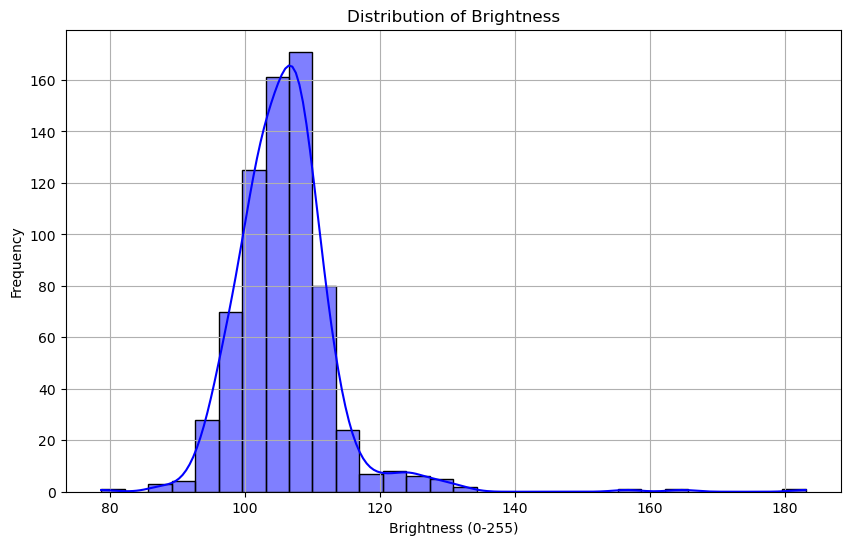

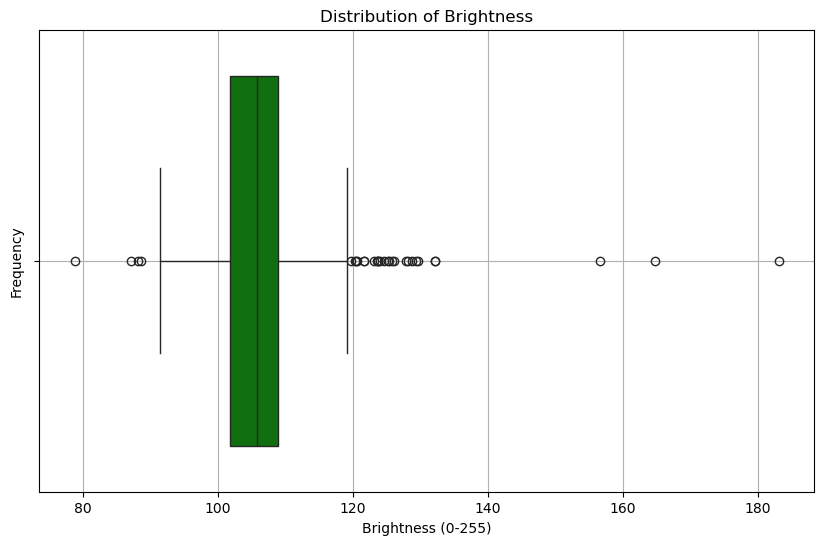

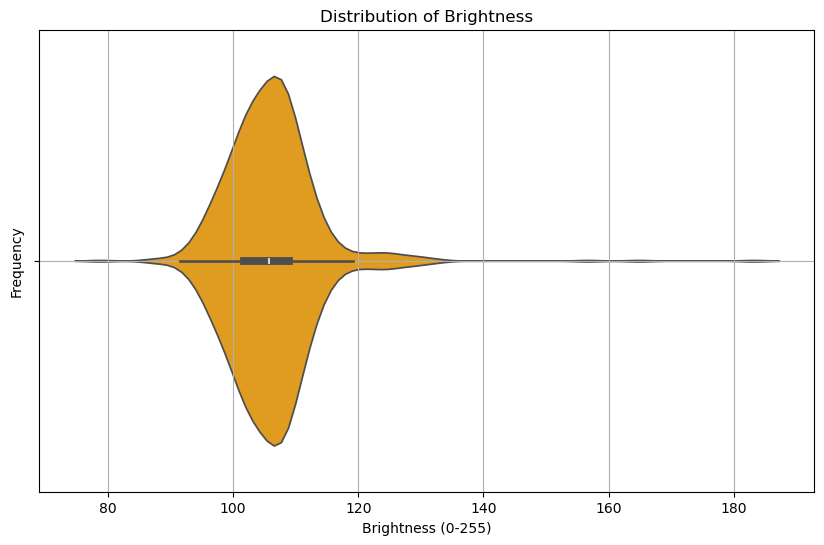

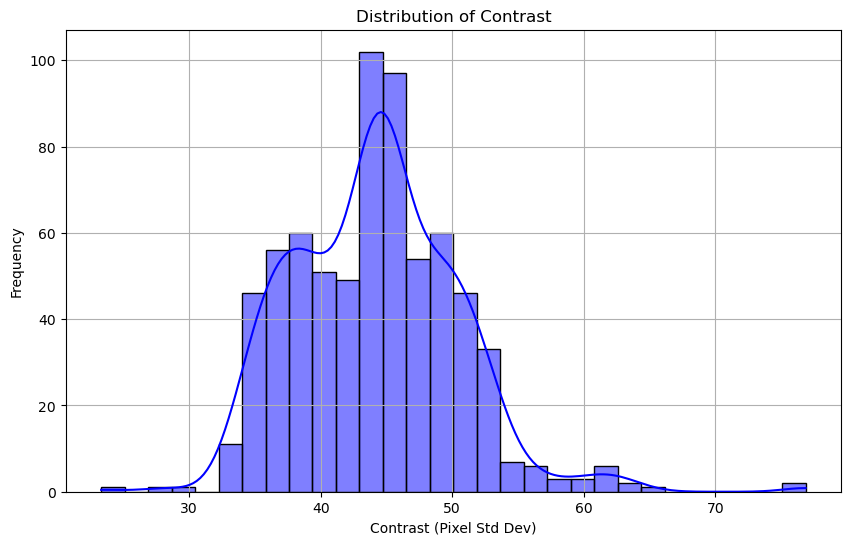

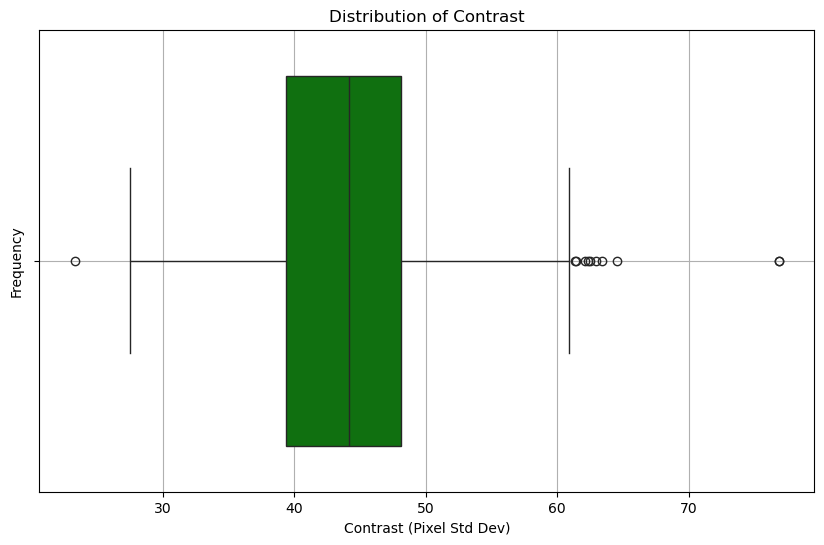

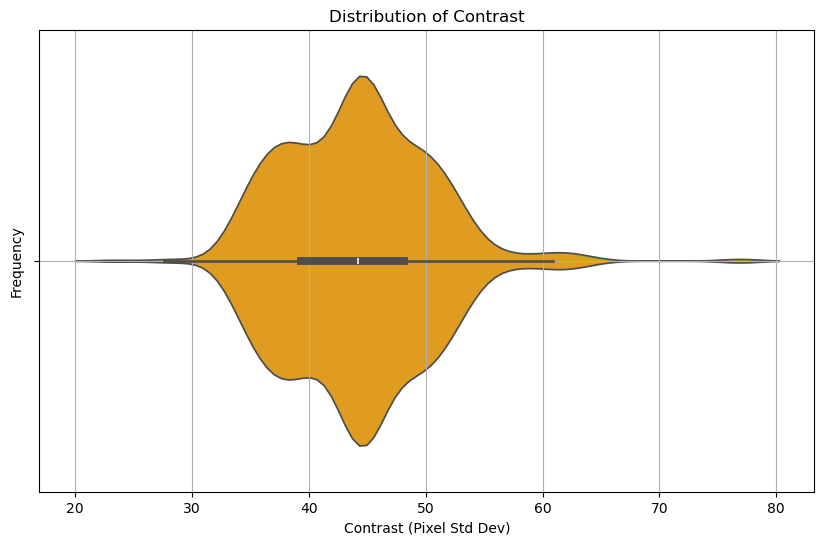

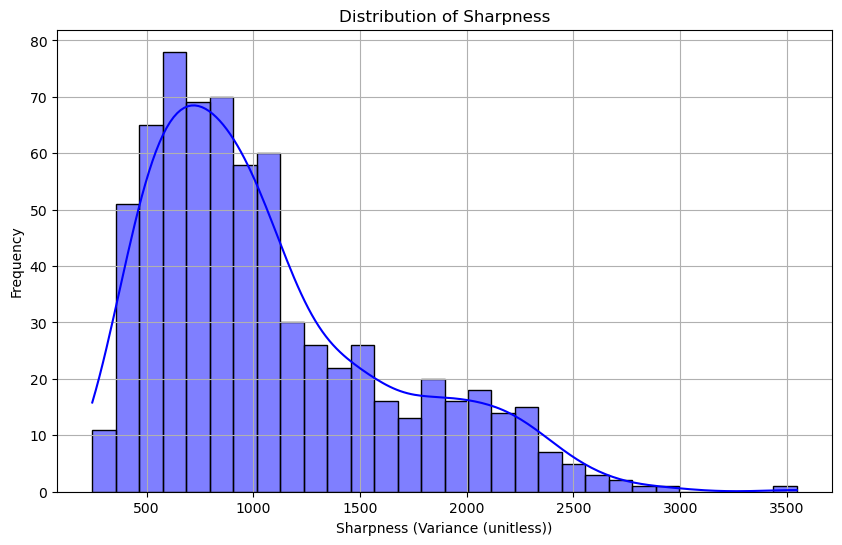

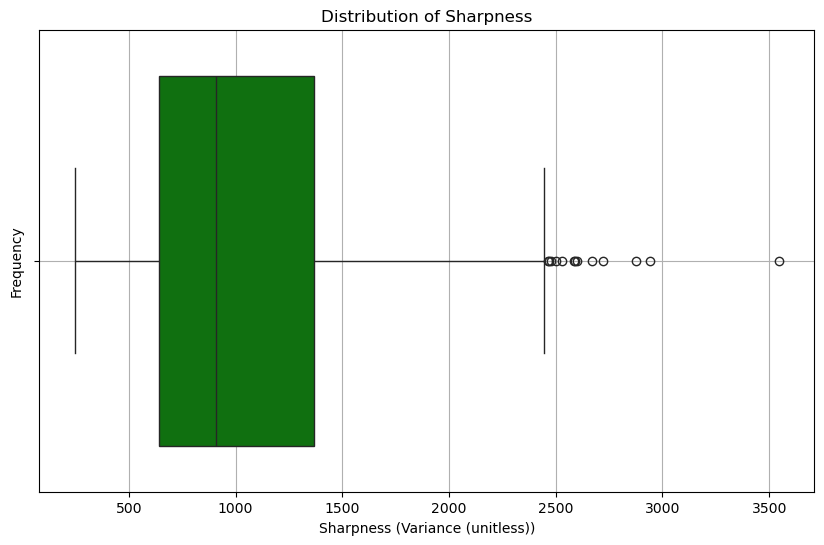

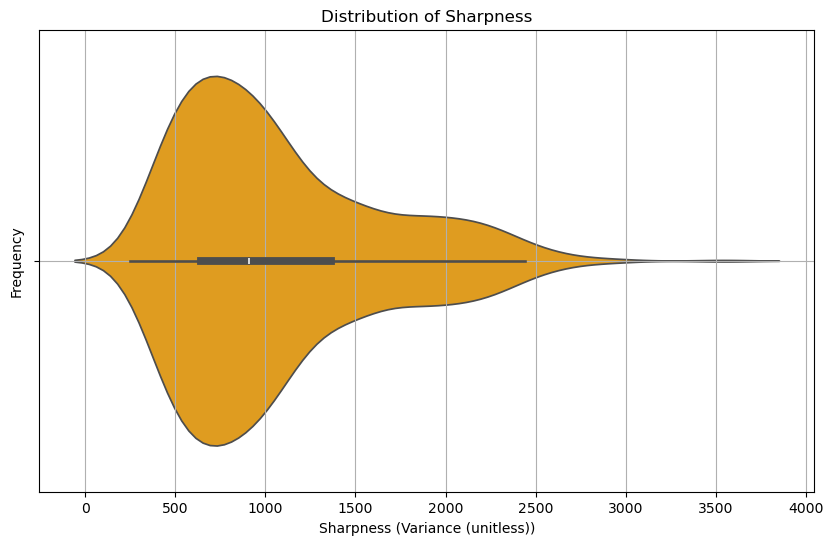

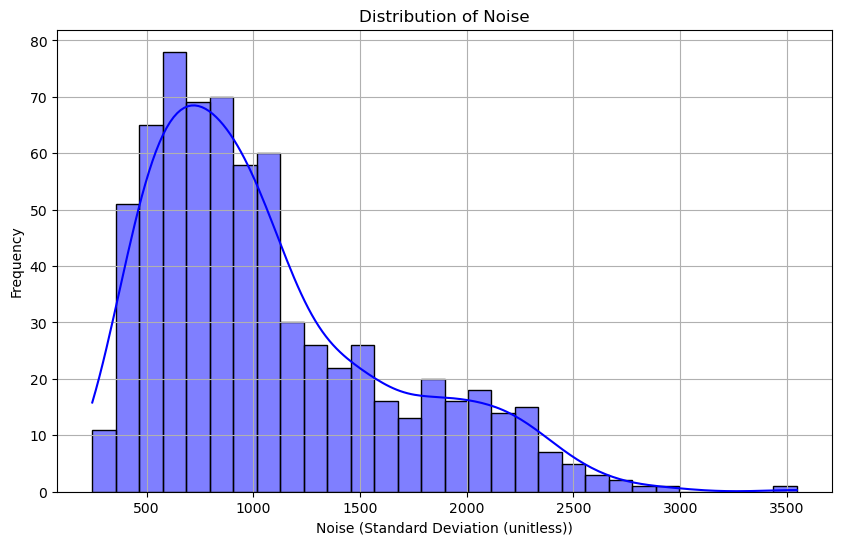

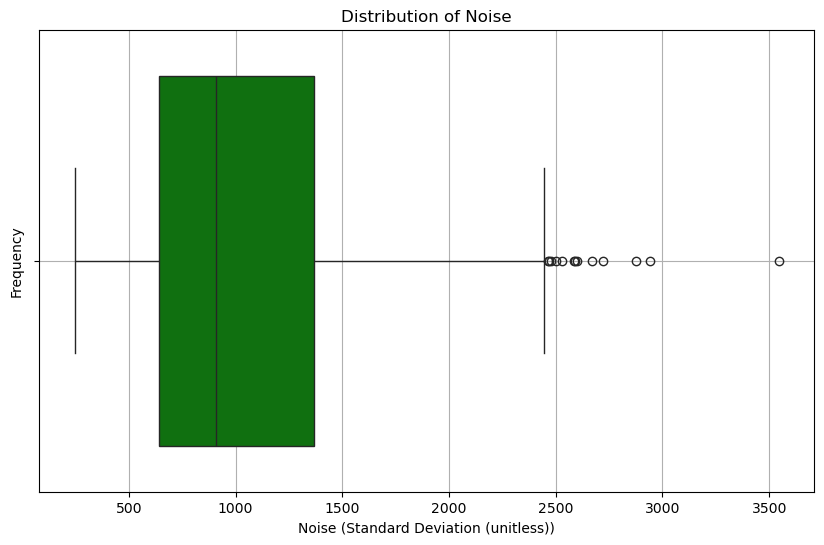

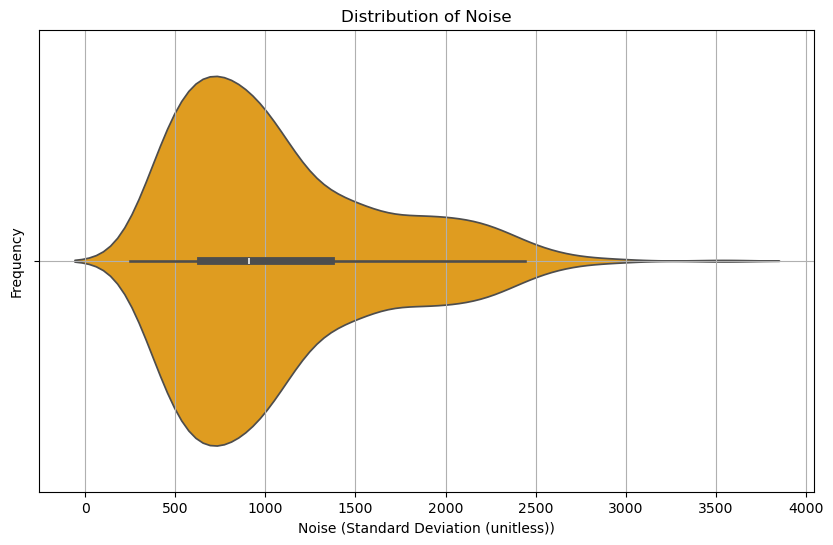

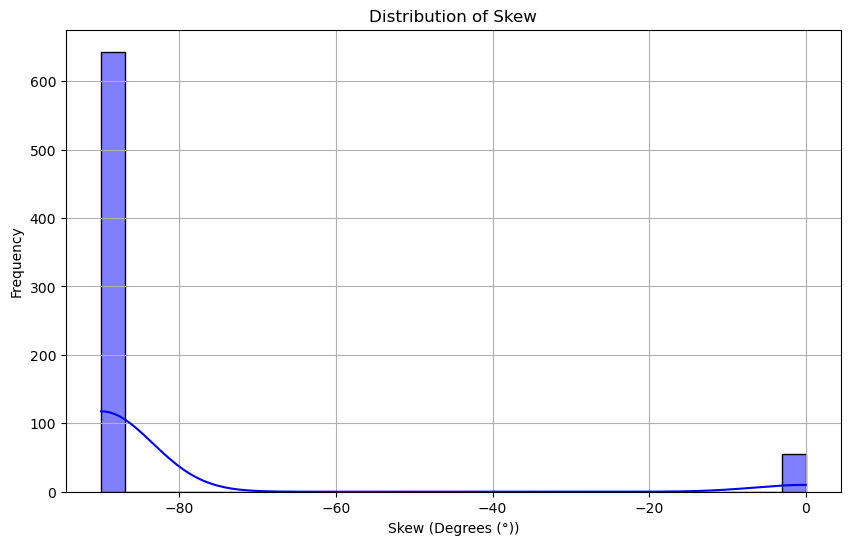

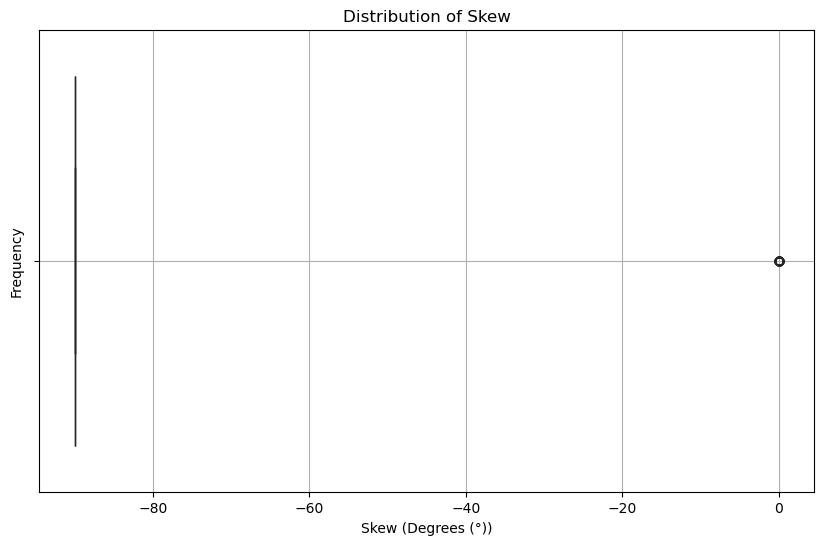

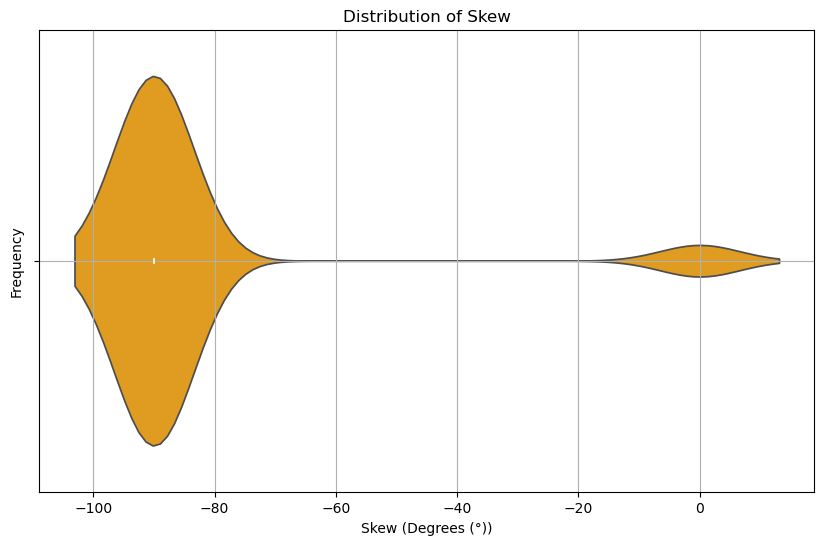

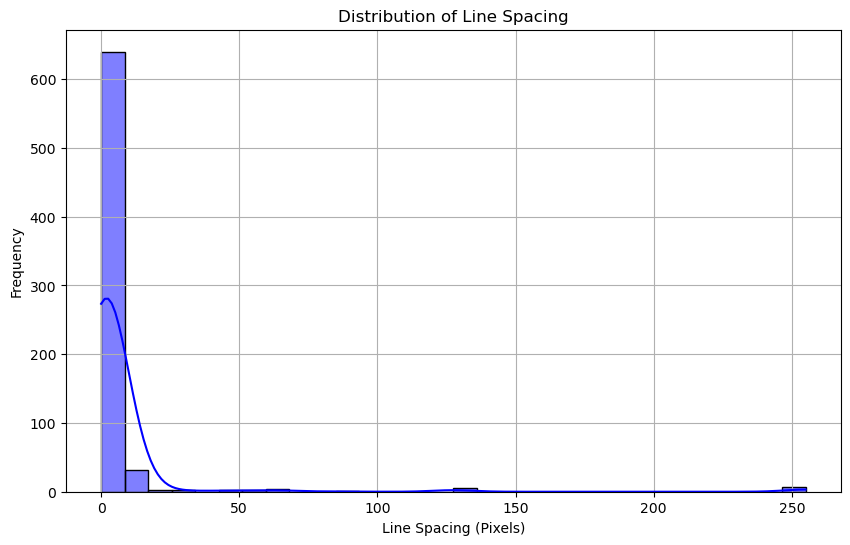

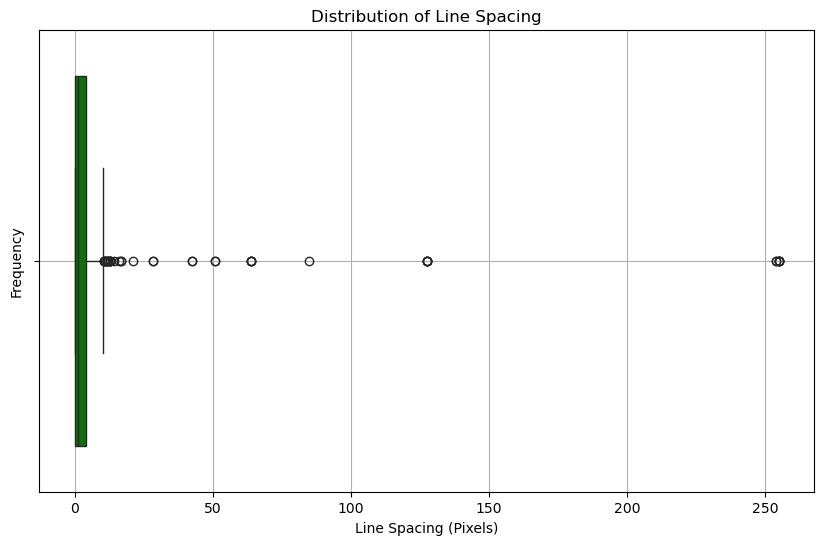

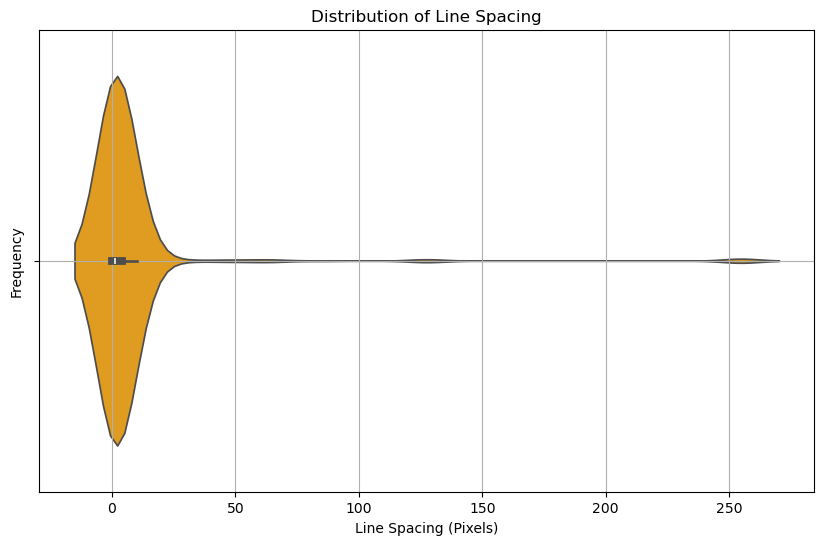

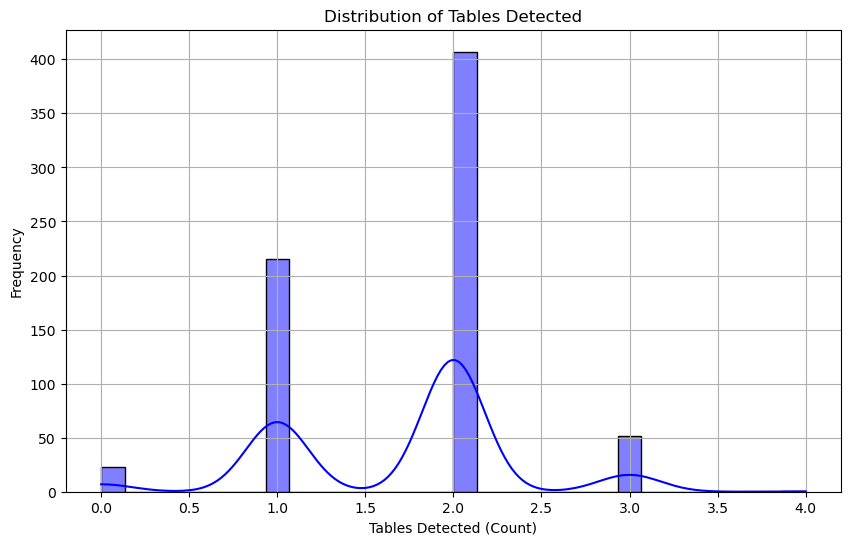

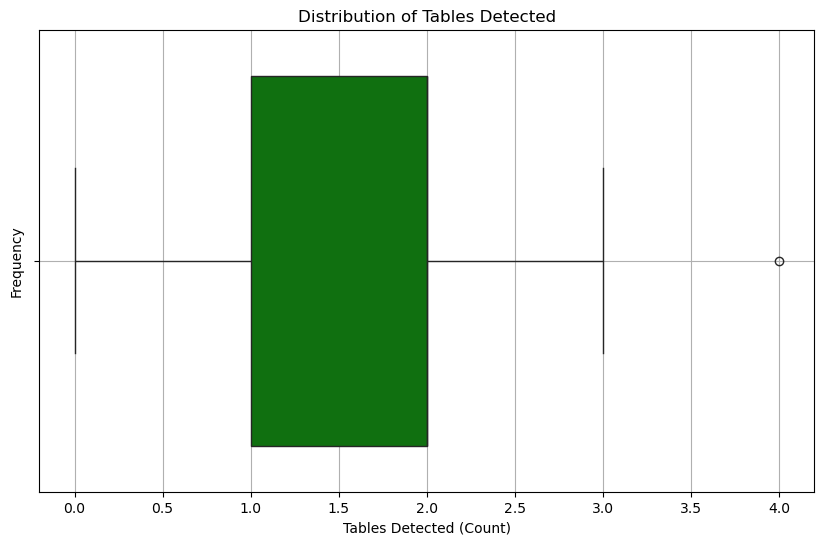

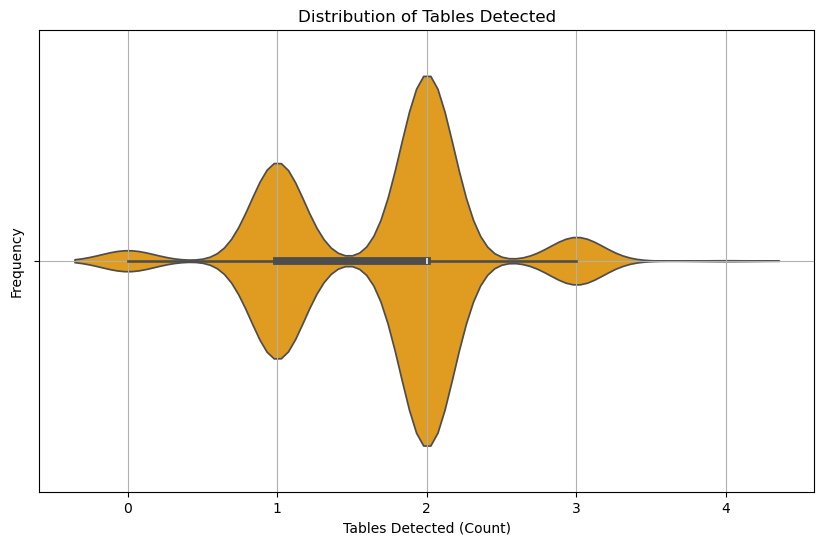

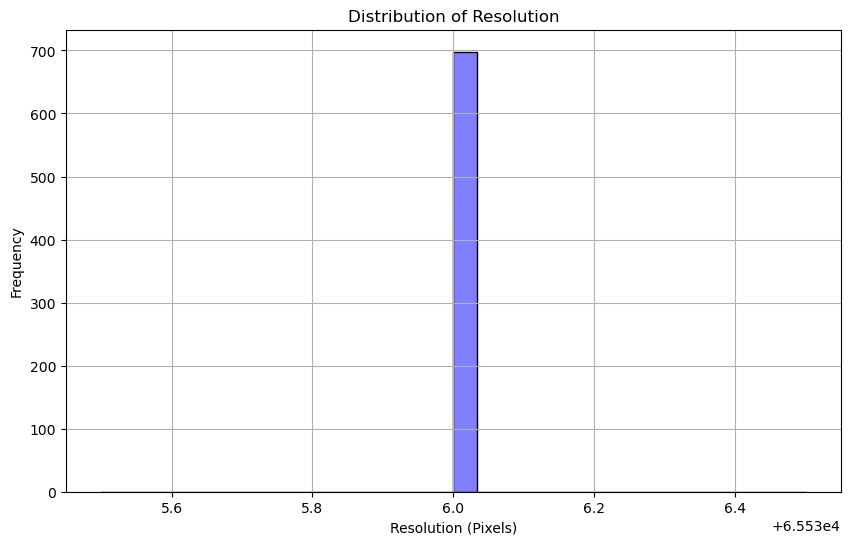

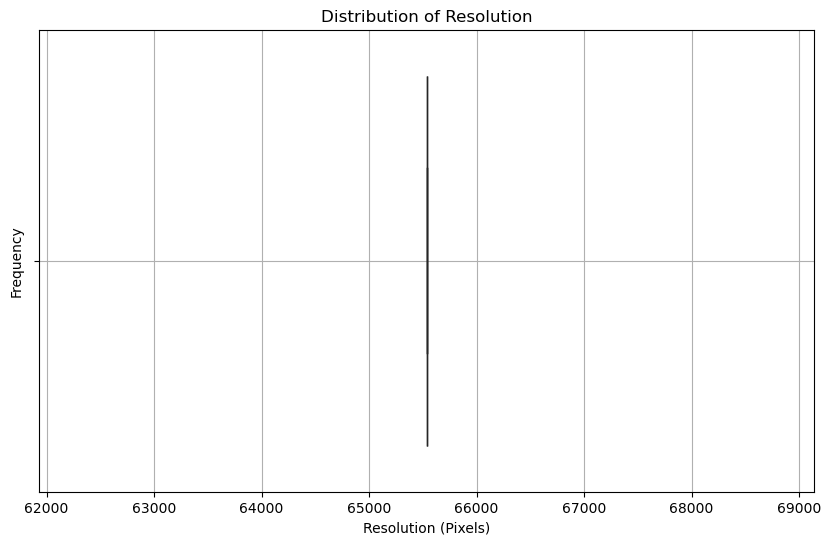

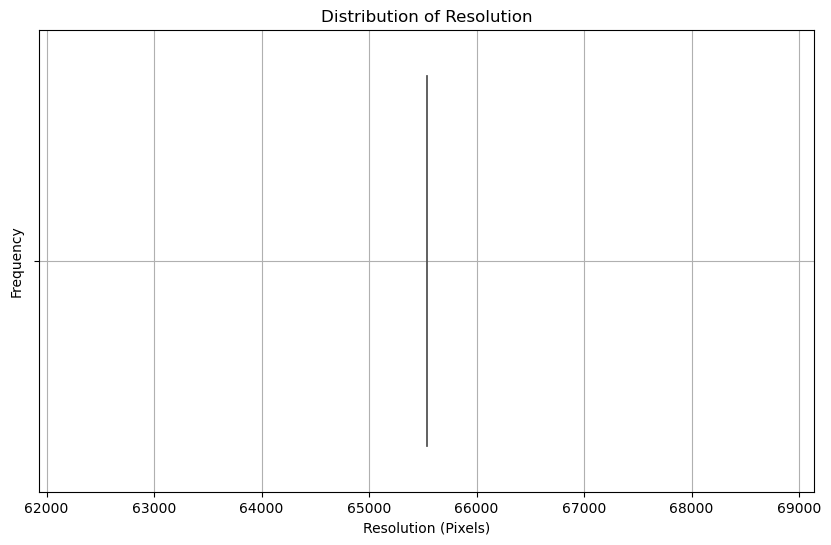

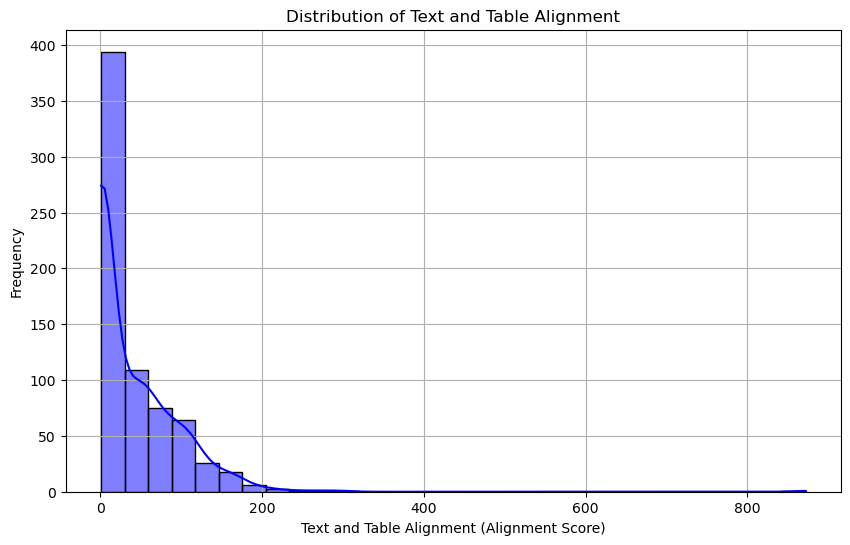

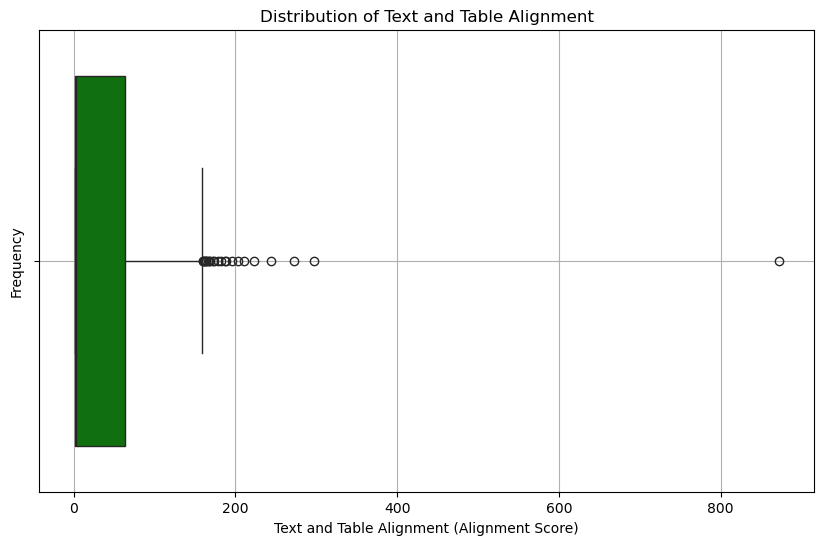

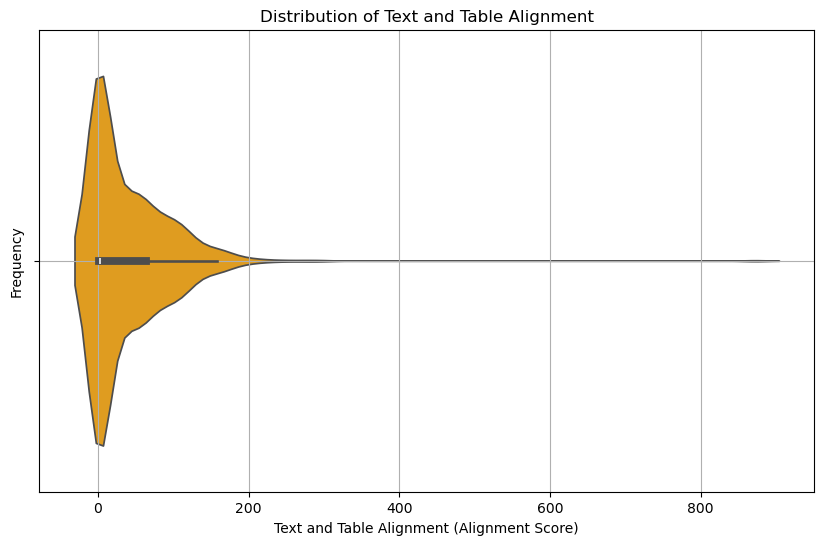

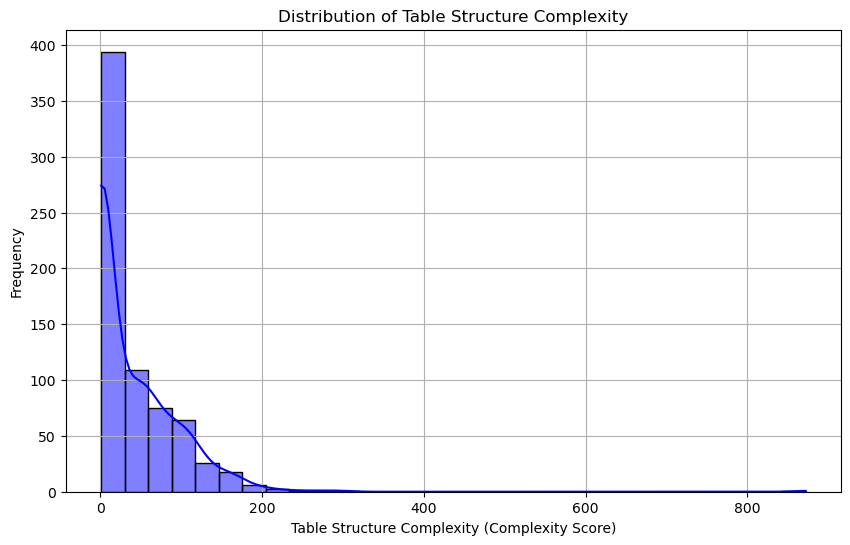

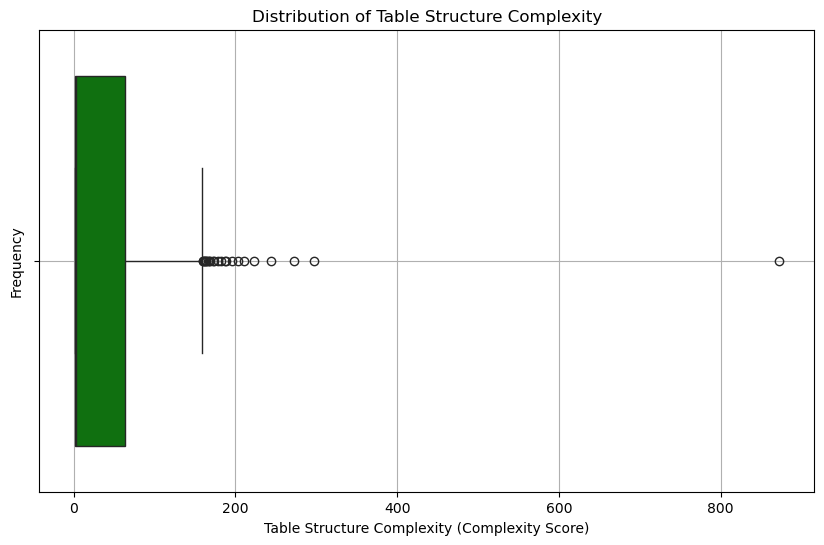

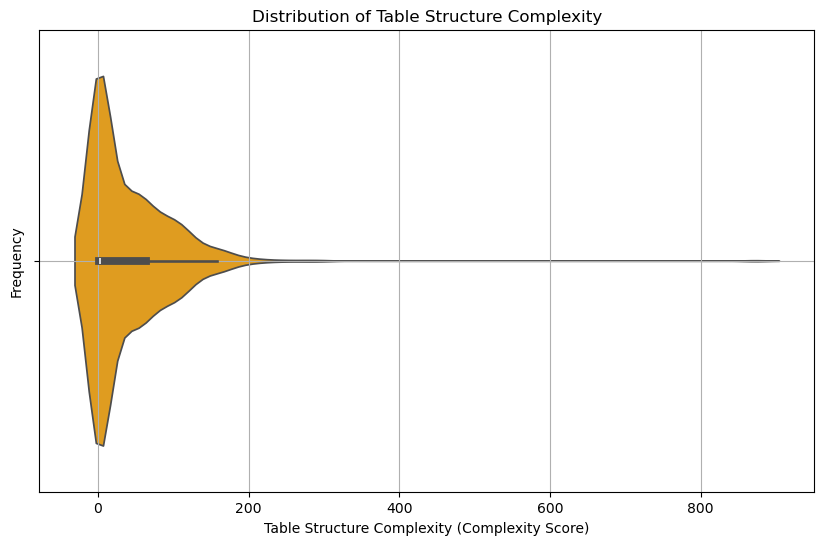

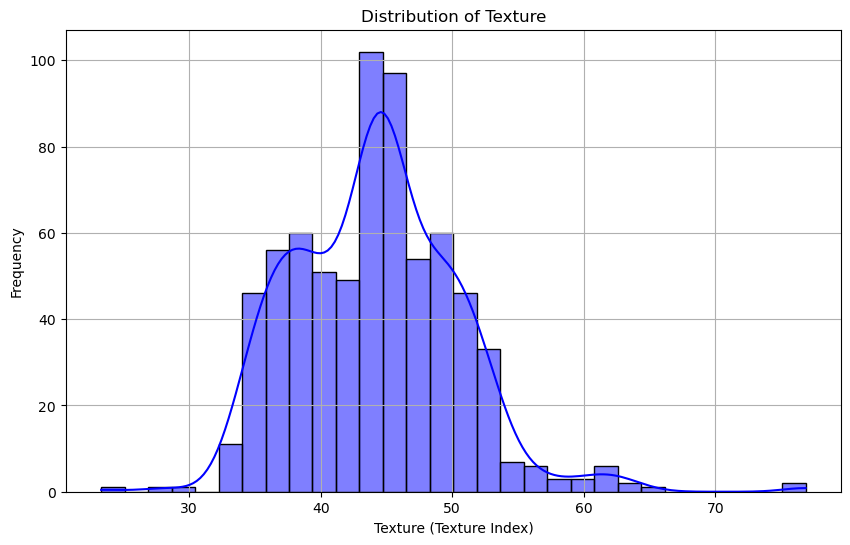

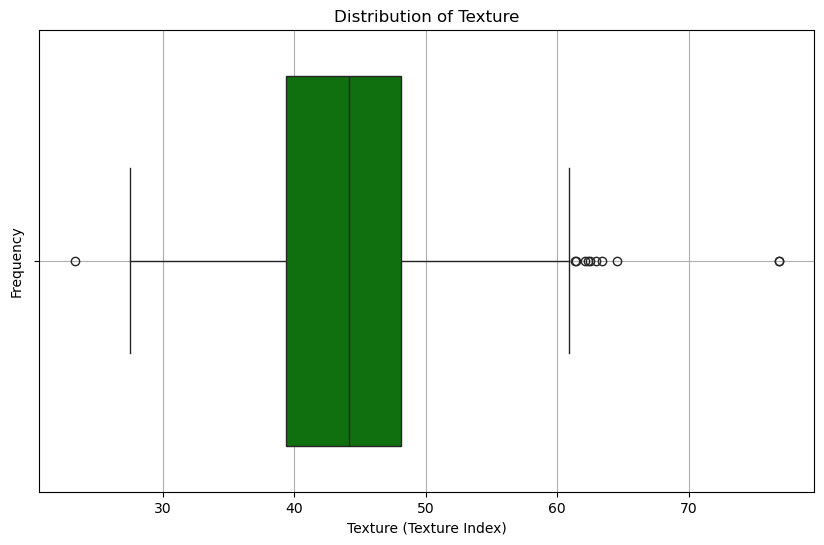

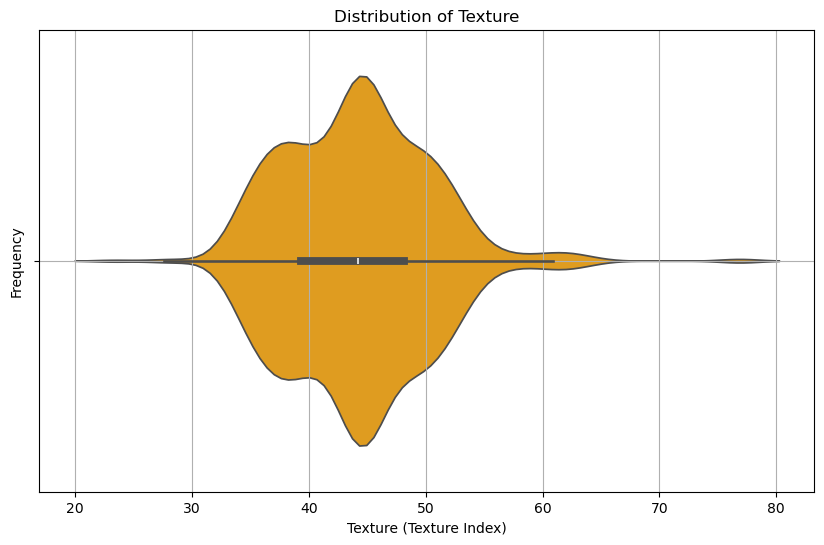

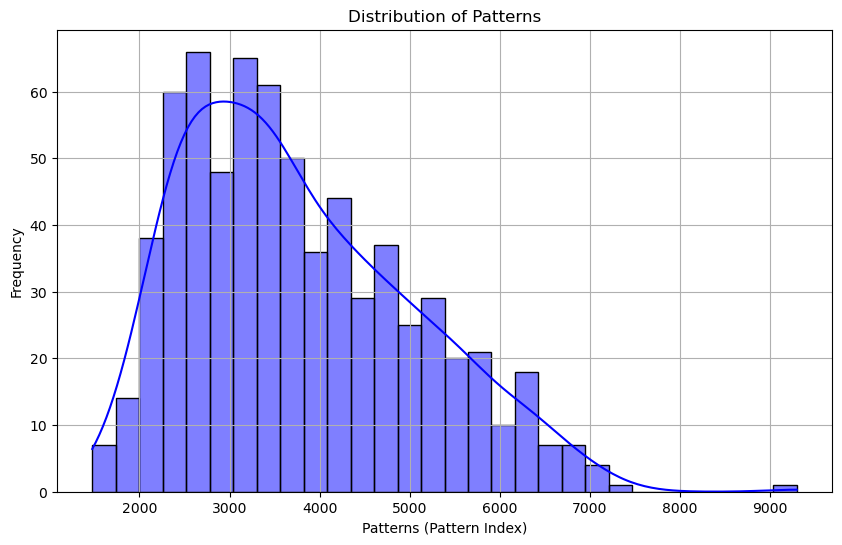

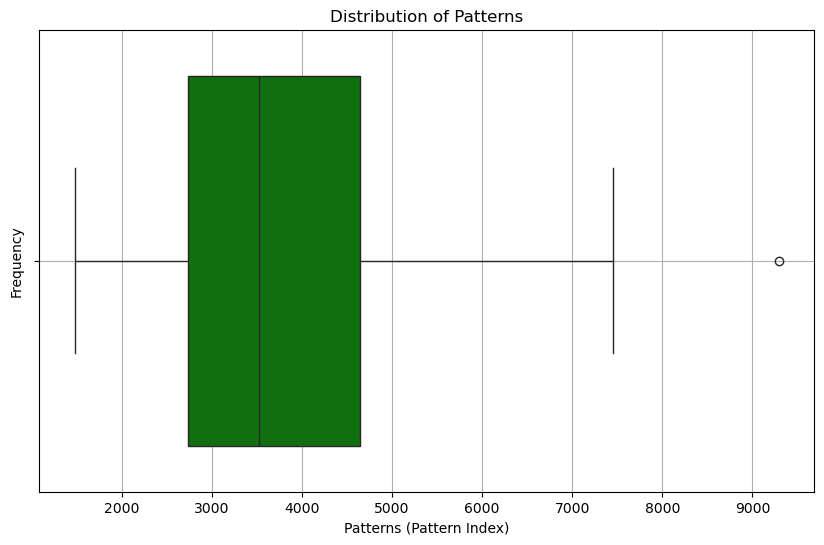

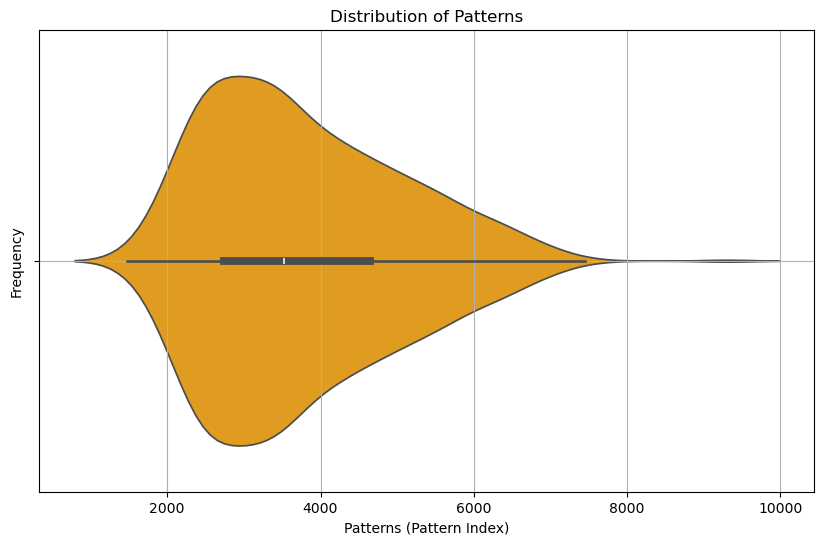

In [32]:
# Loop through each characteristic and its corresponding unit
for characteristic, unit in characteristics_units.items():
    for plot_type in ['hist', 'box', 'violin']:
        plot_characteristic_distribution(df_stats, characteristic, unit, plot_type)

#### Distribution of Brightness

### Step 5: Visualize relationships between characteristics

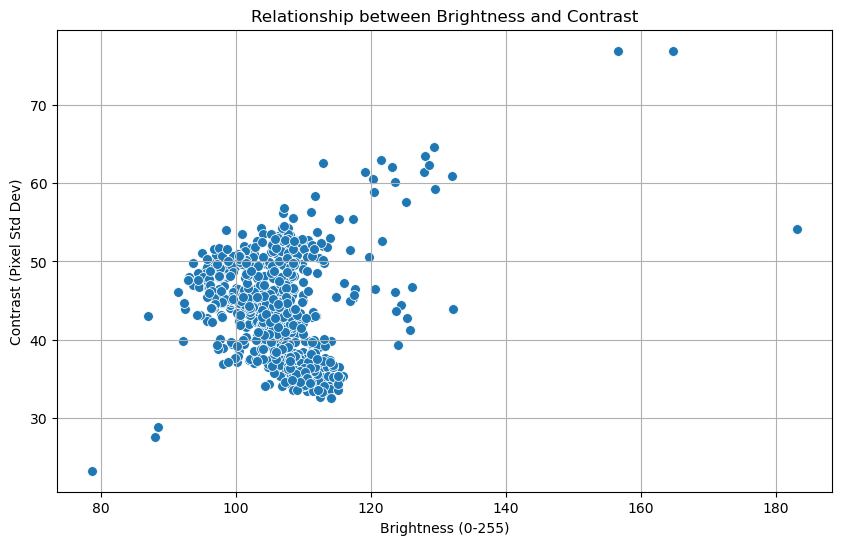

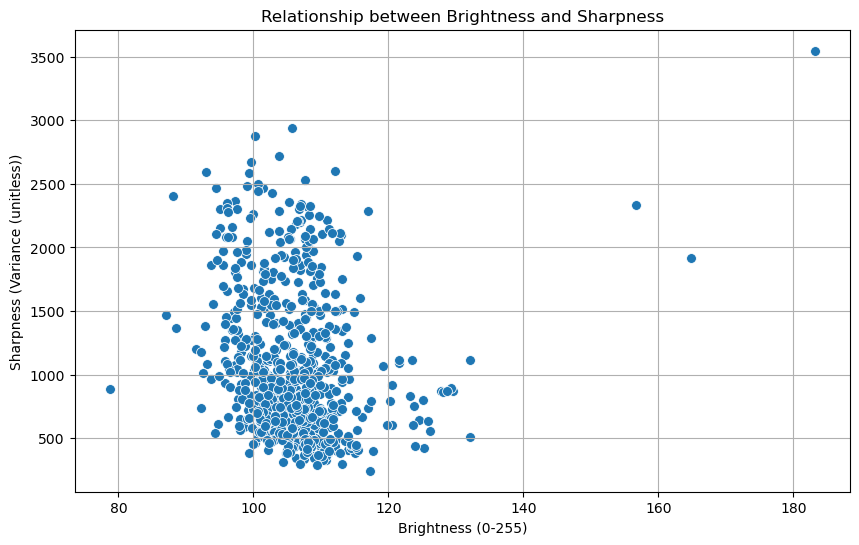

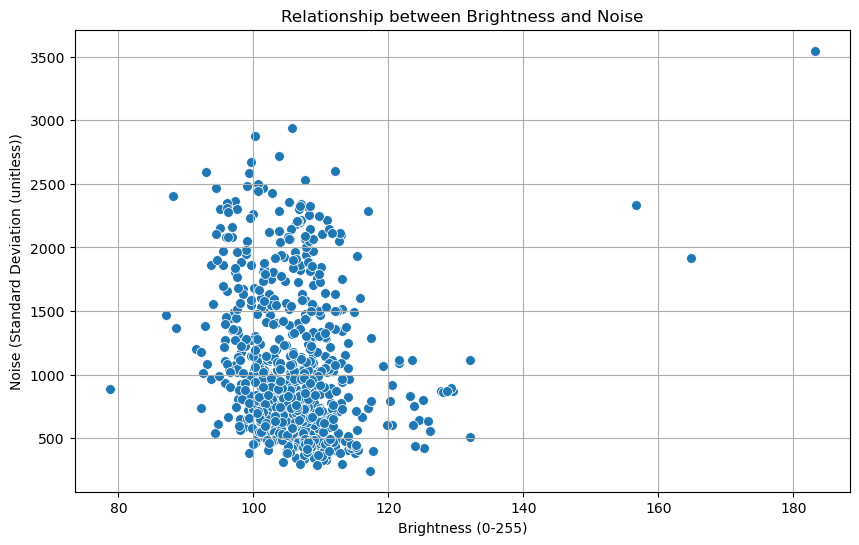

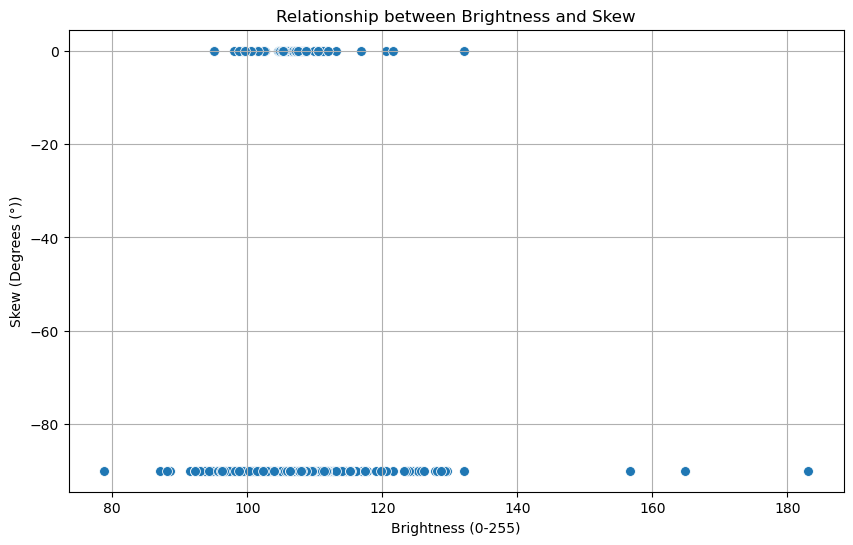

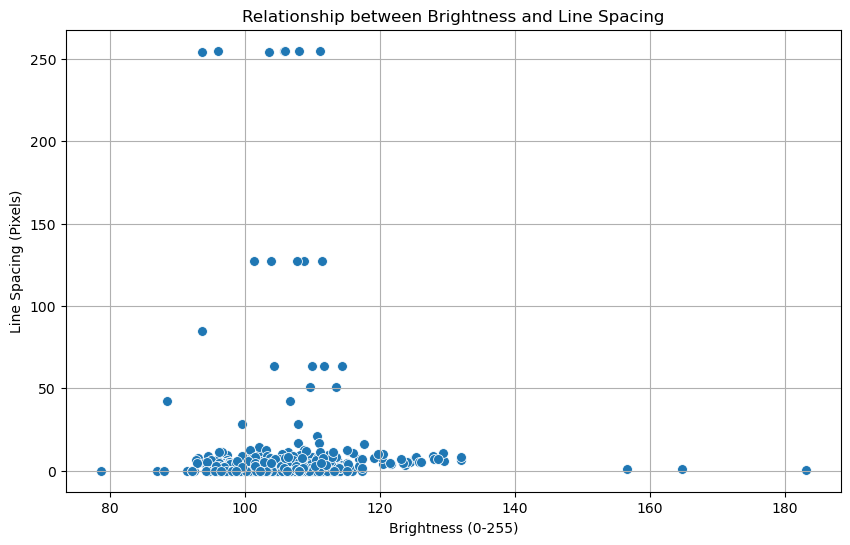

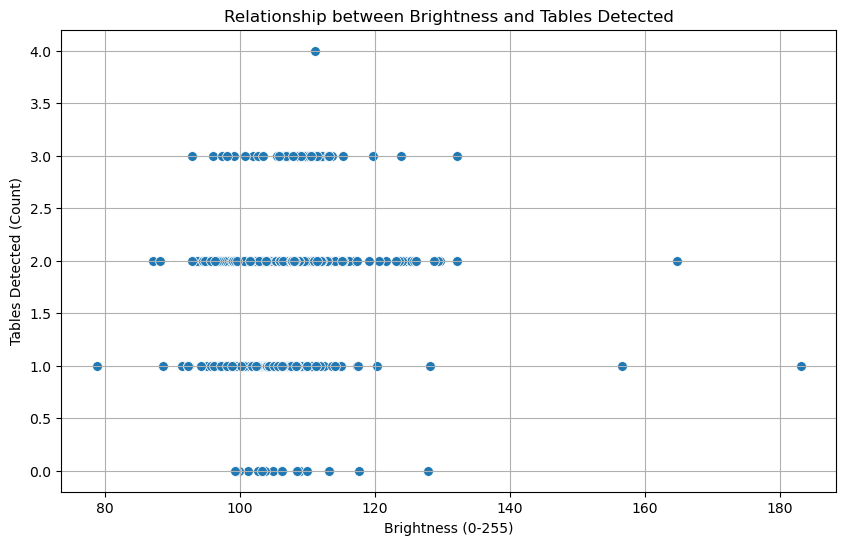

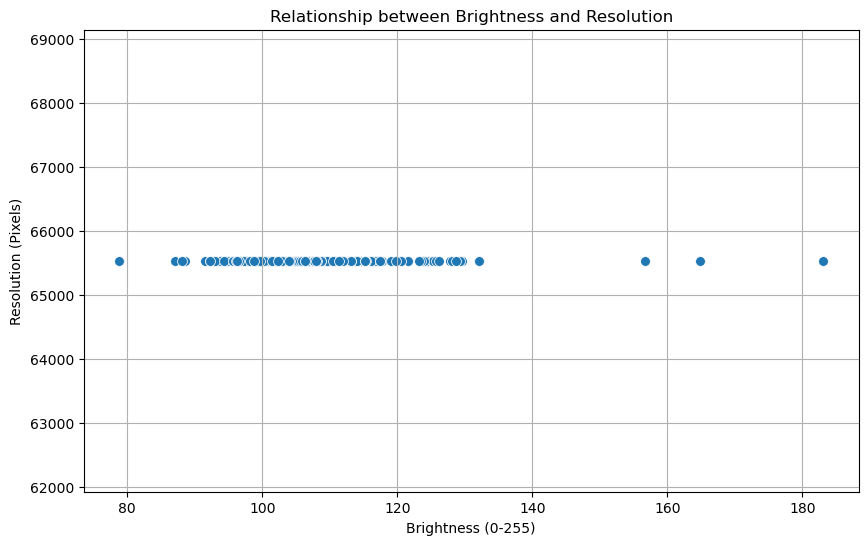

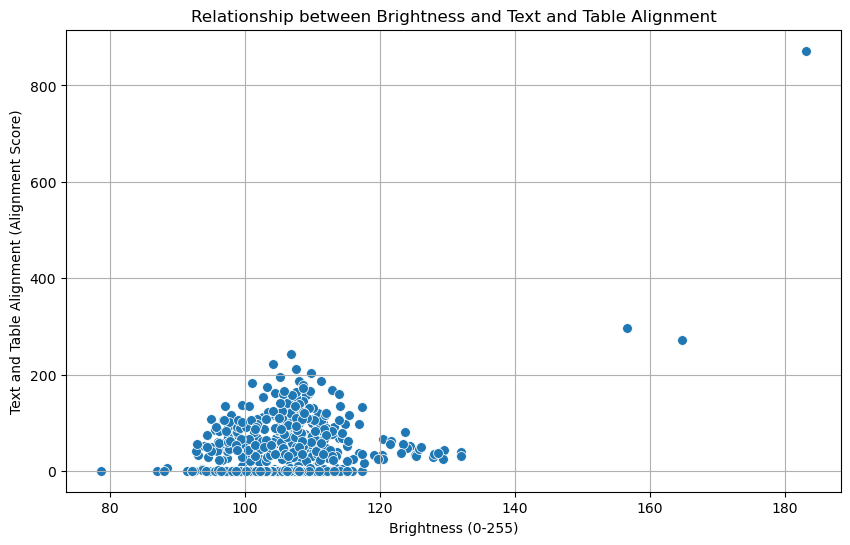

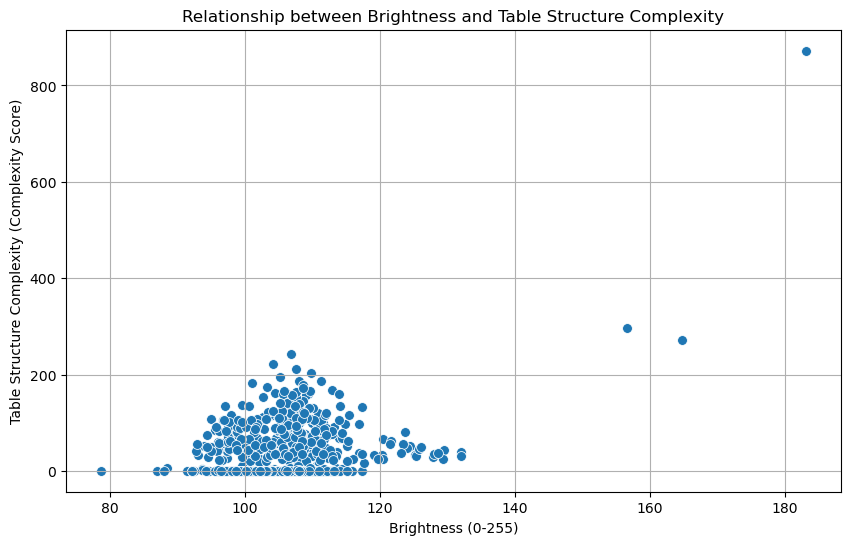

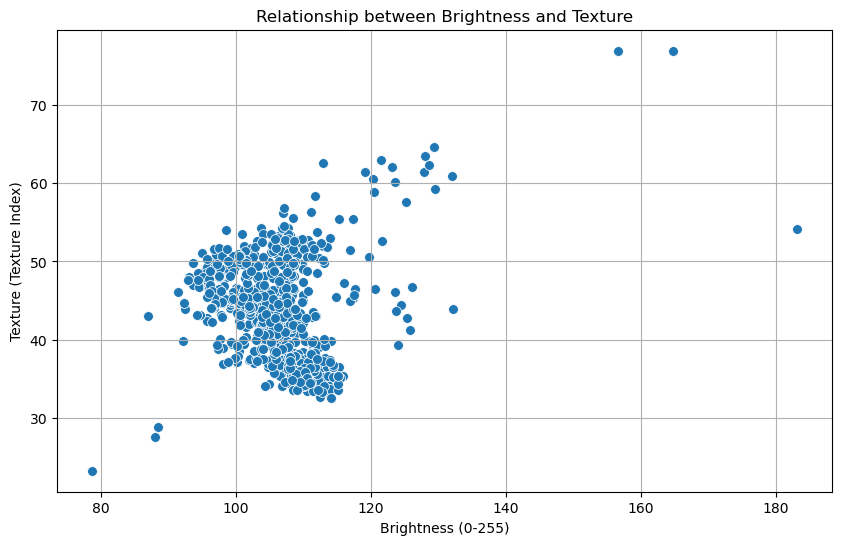

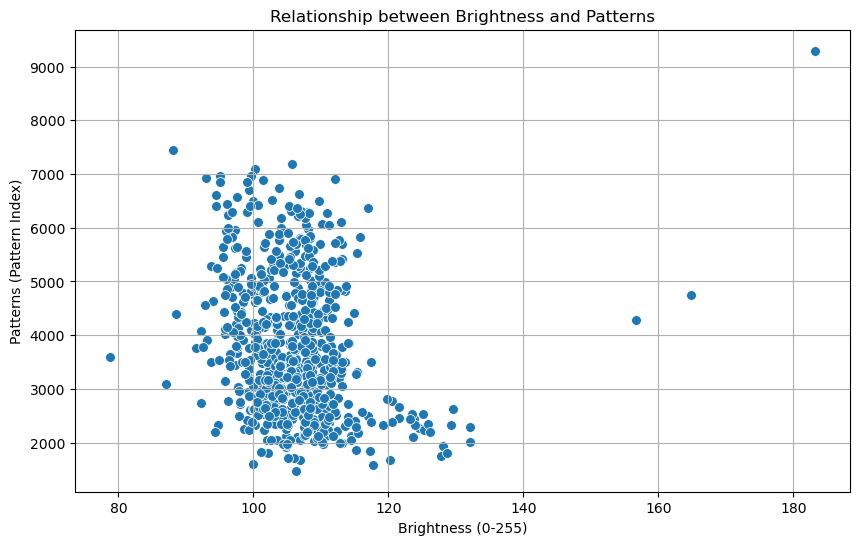

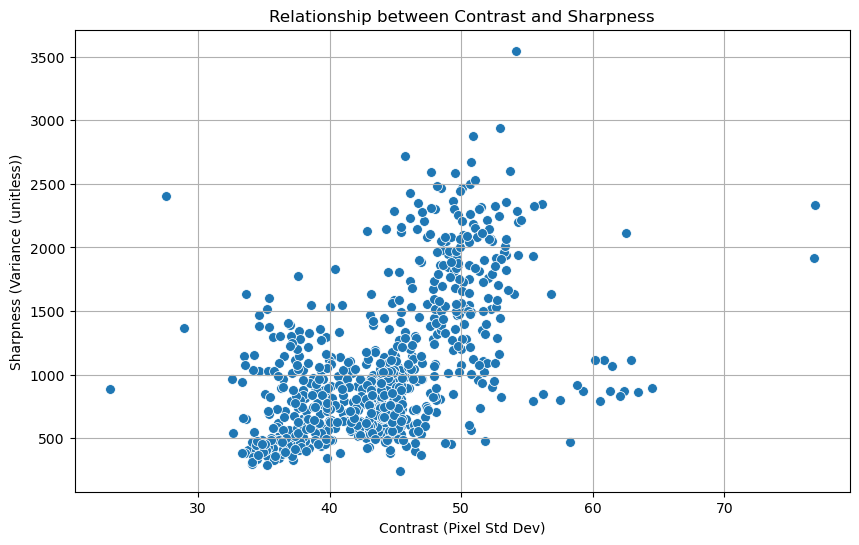

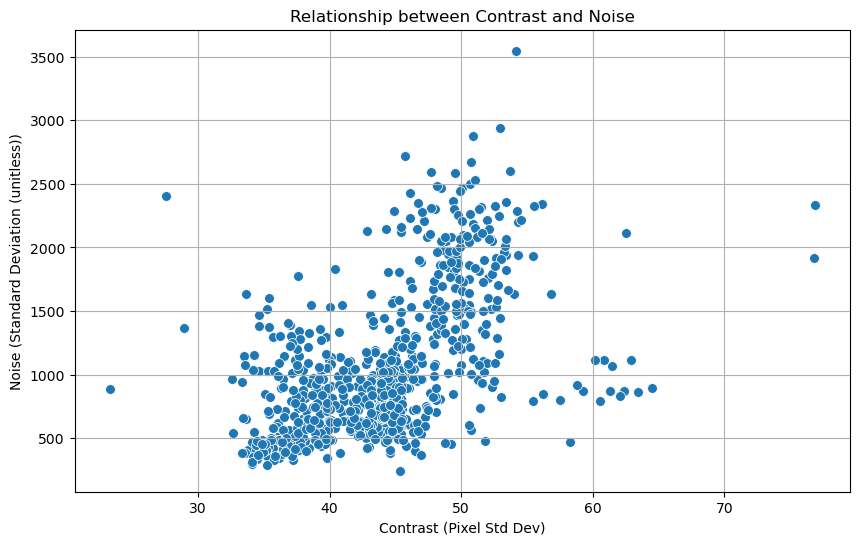

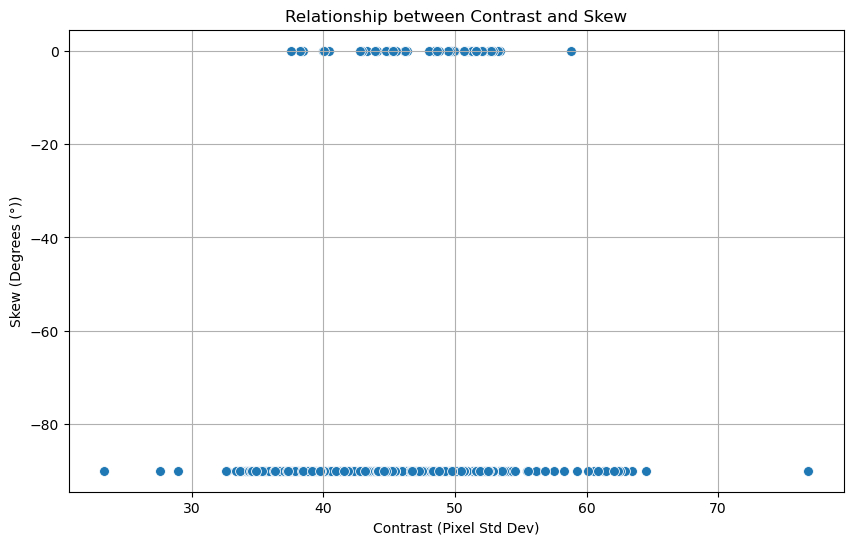

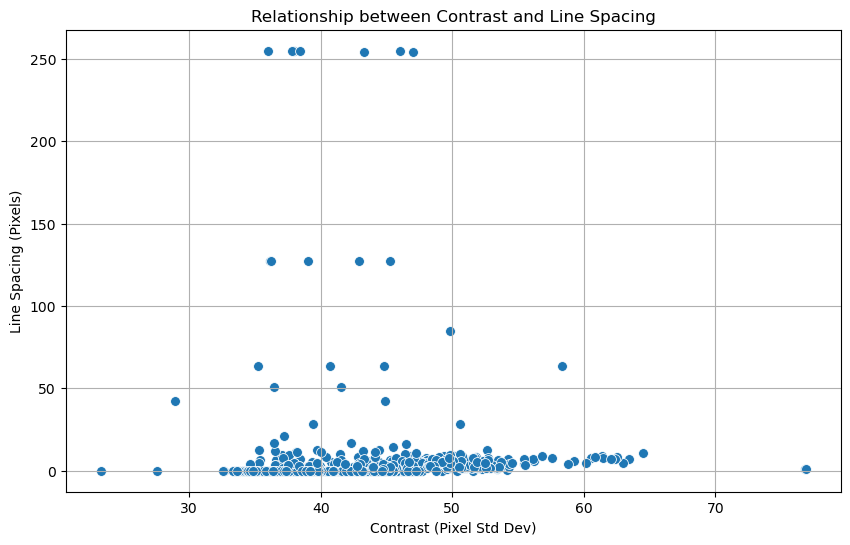

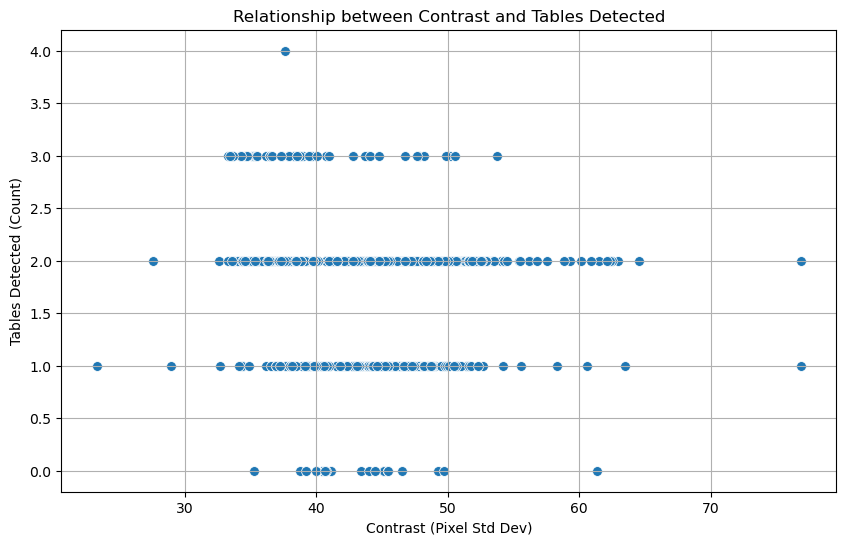

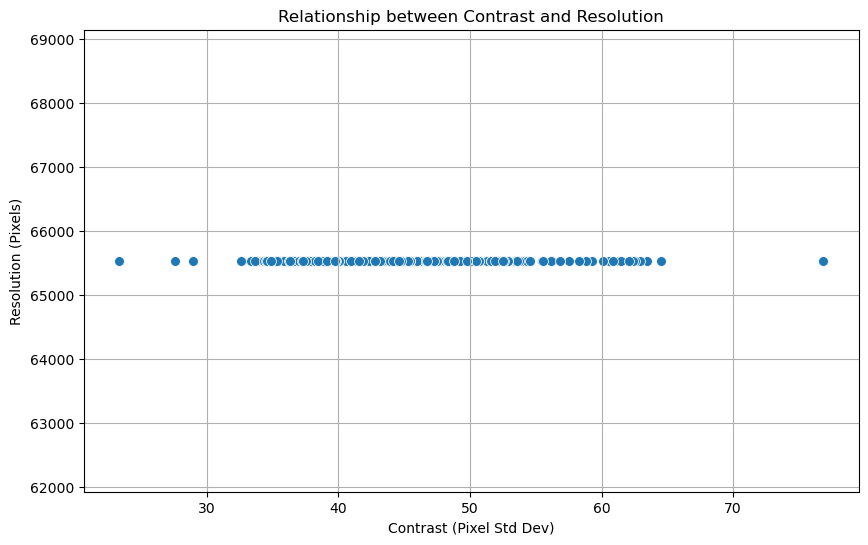

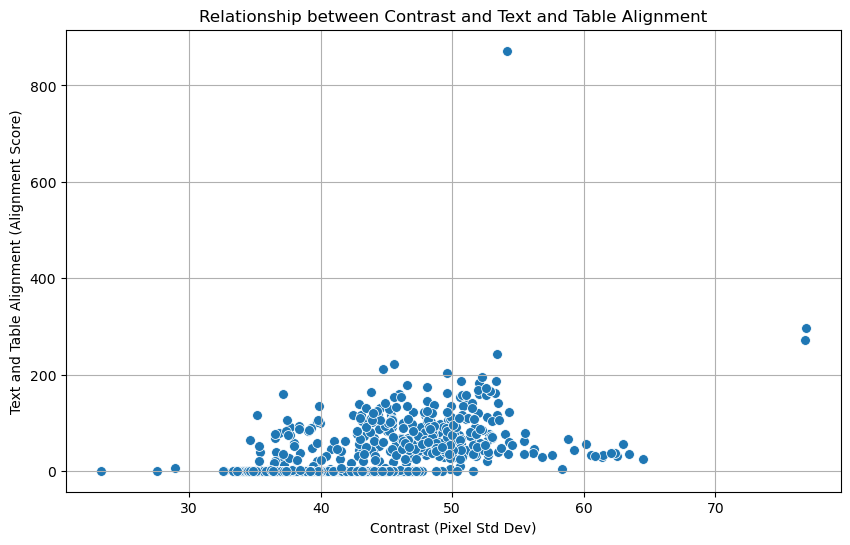

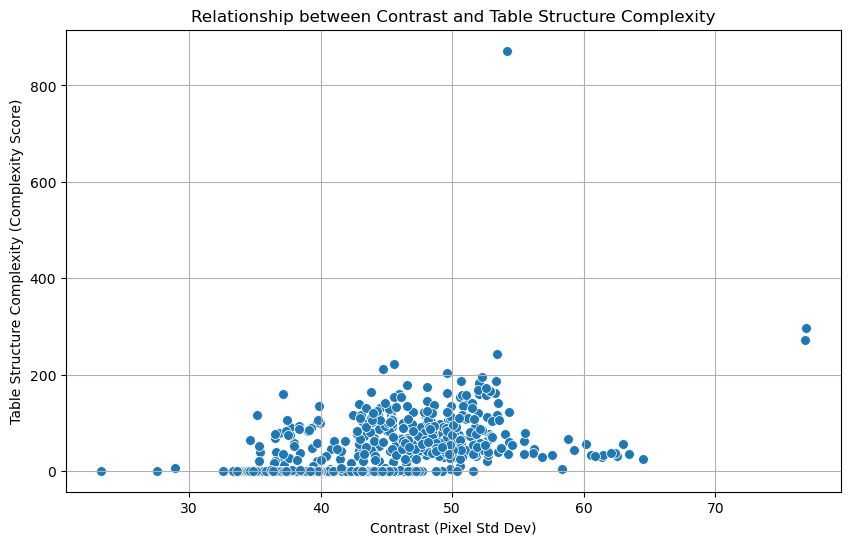

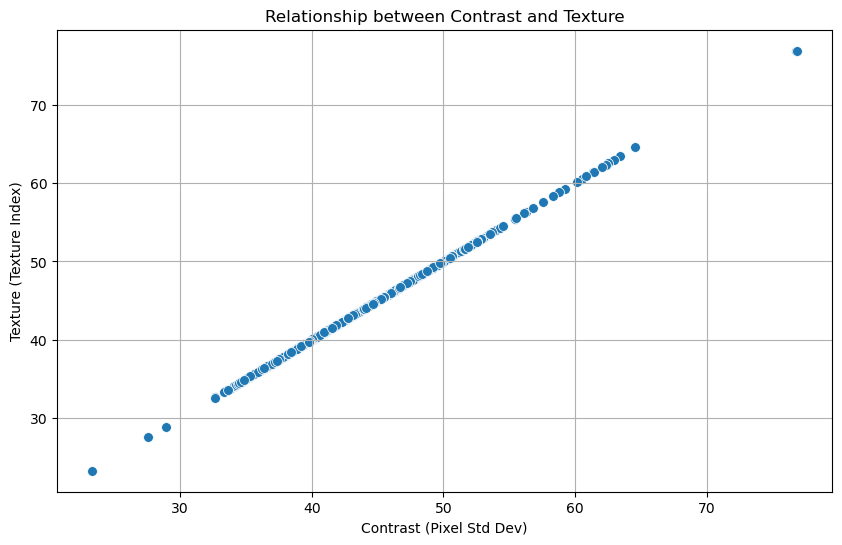

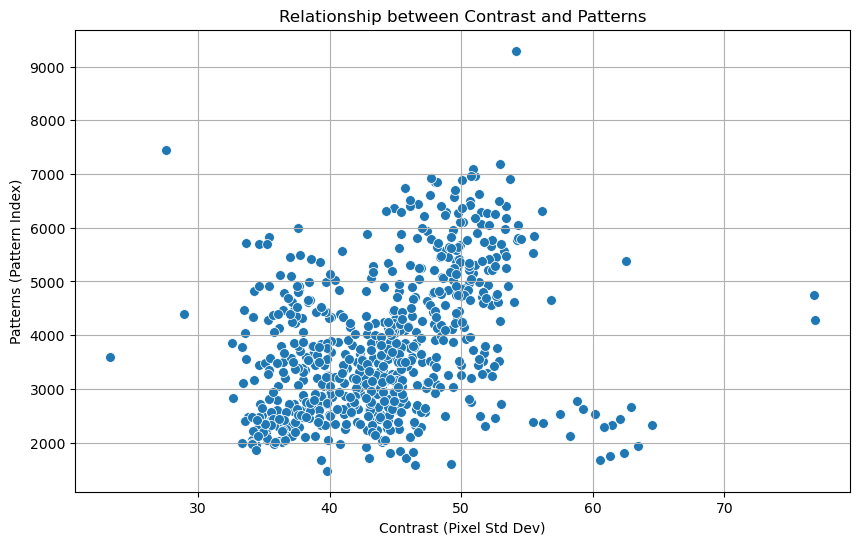

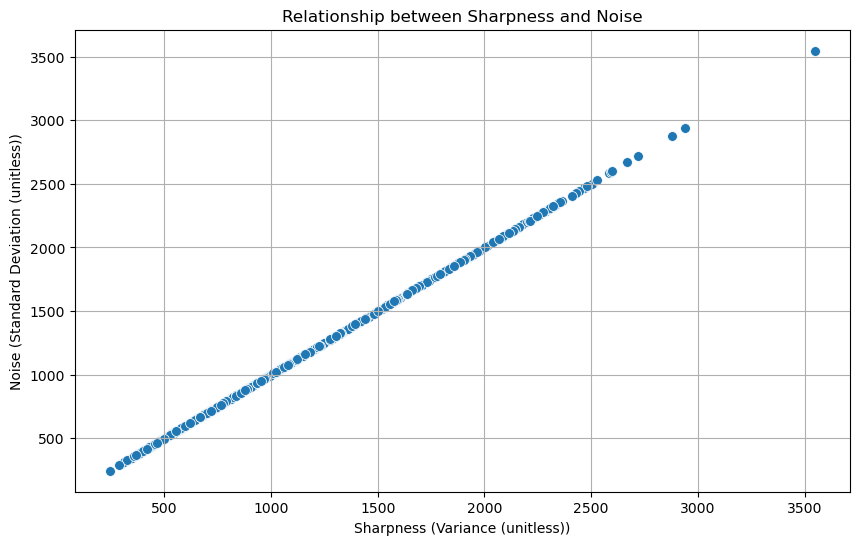

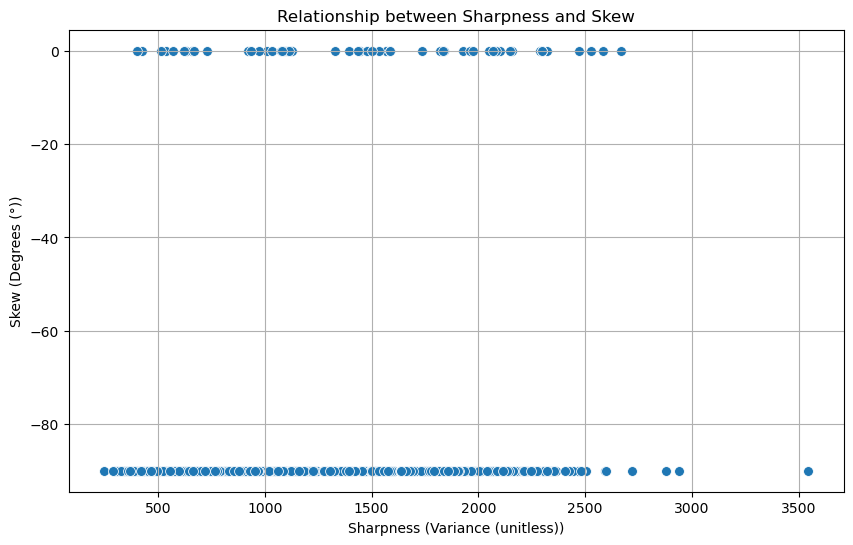

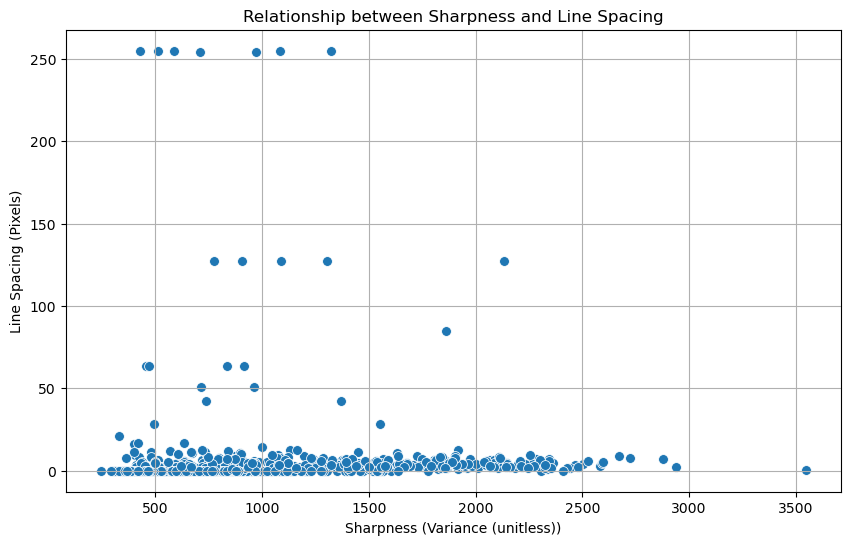

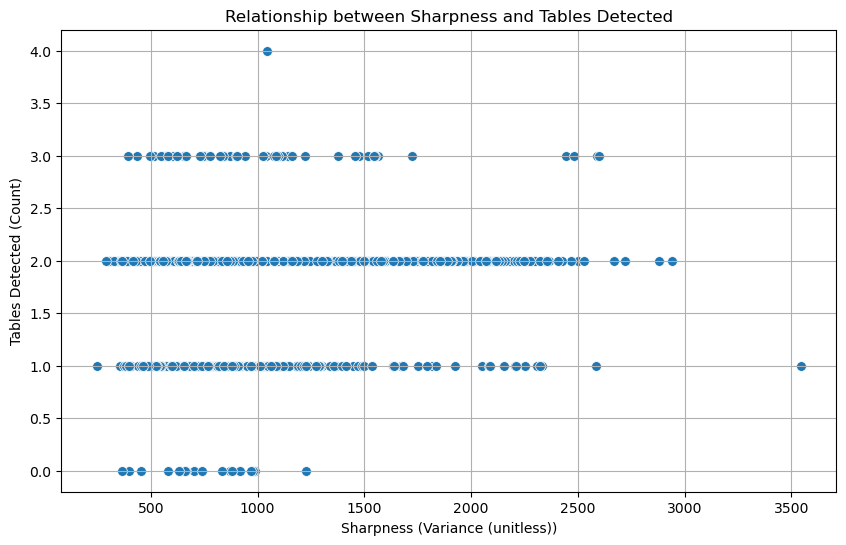

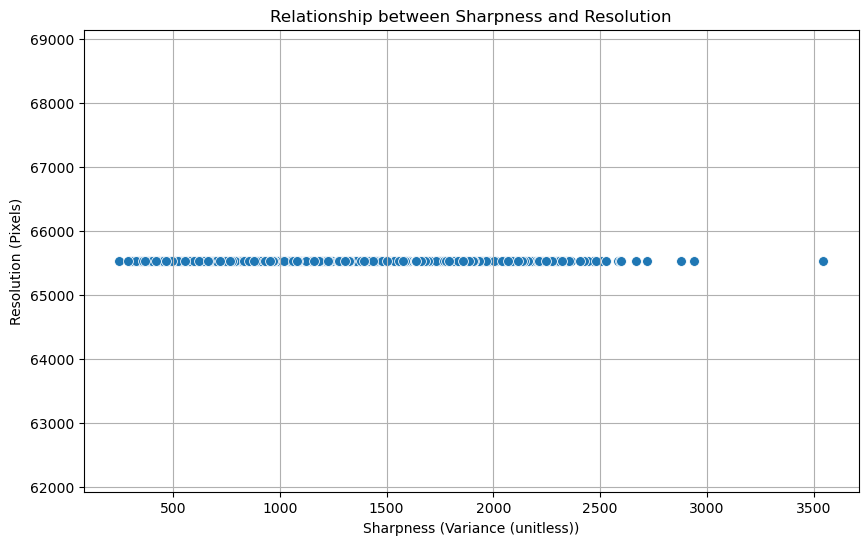

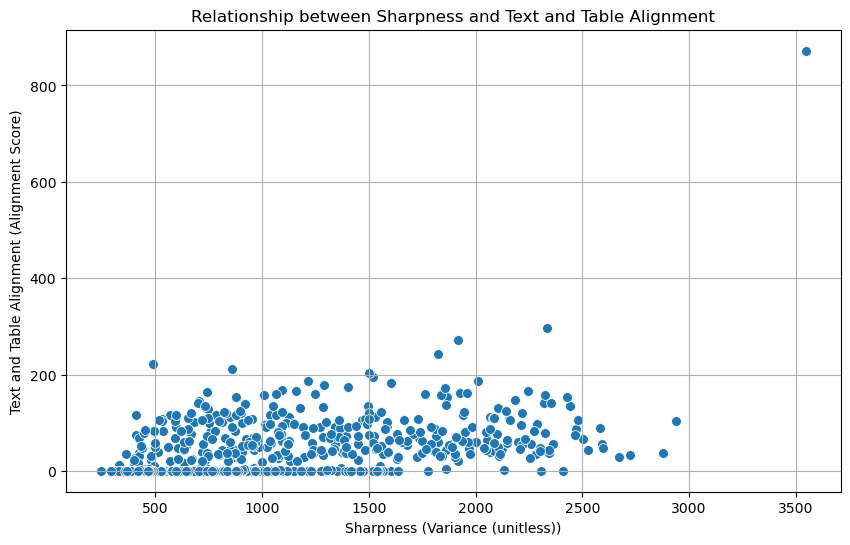

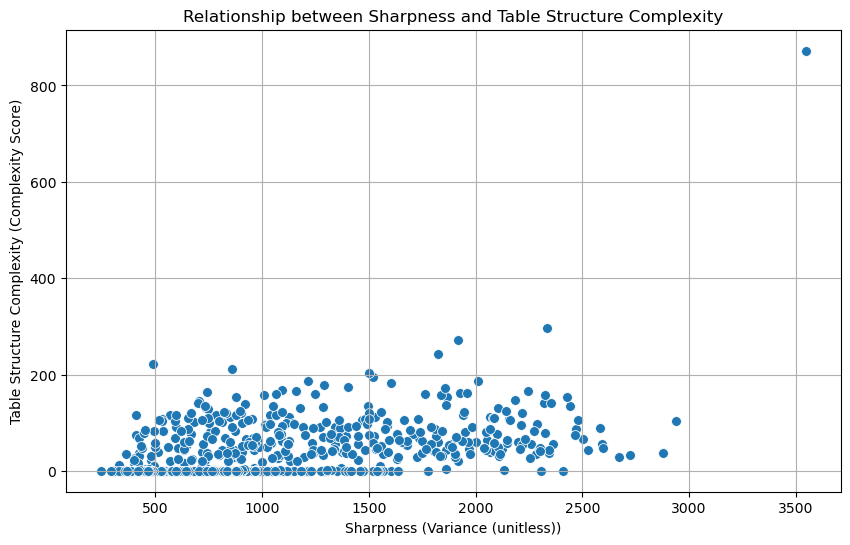

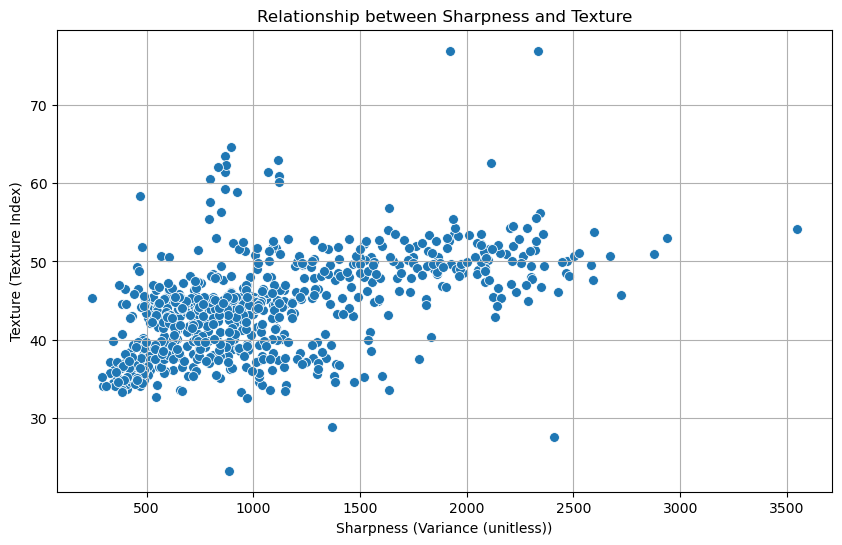

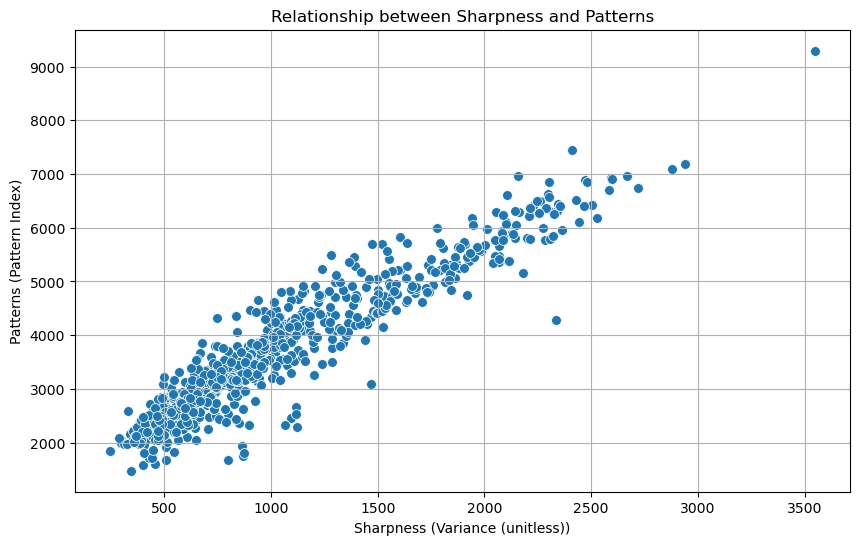

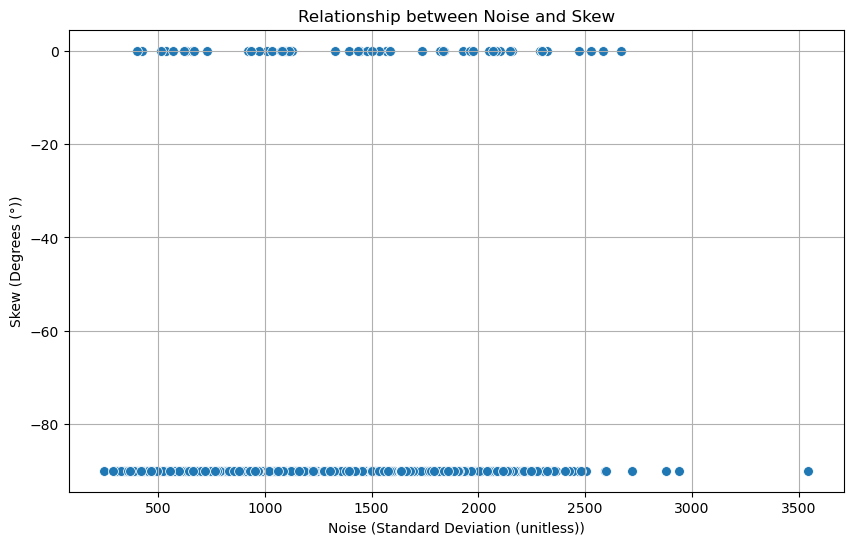

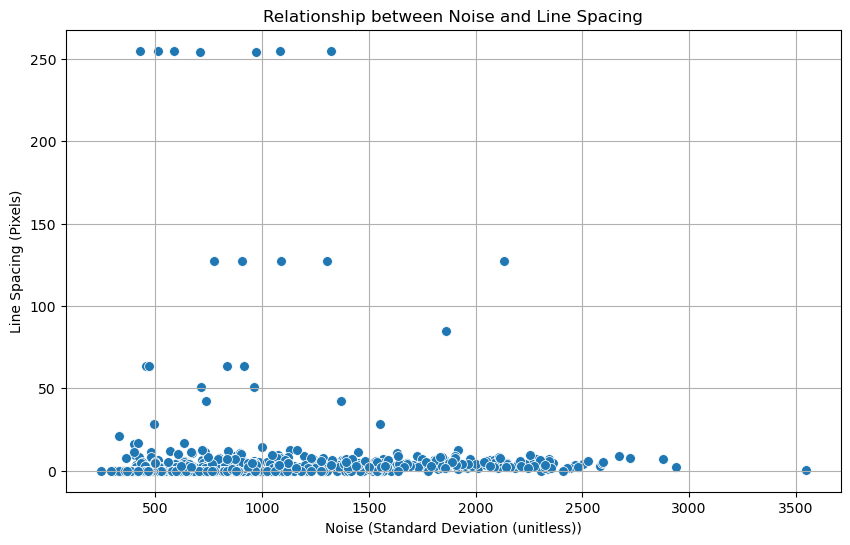

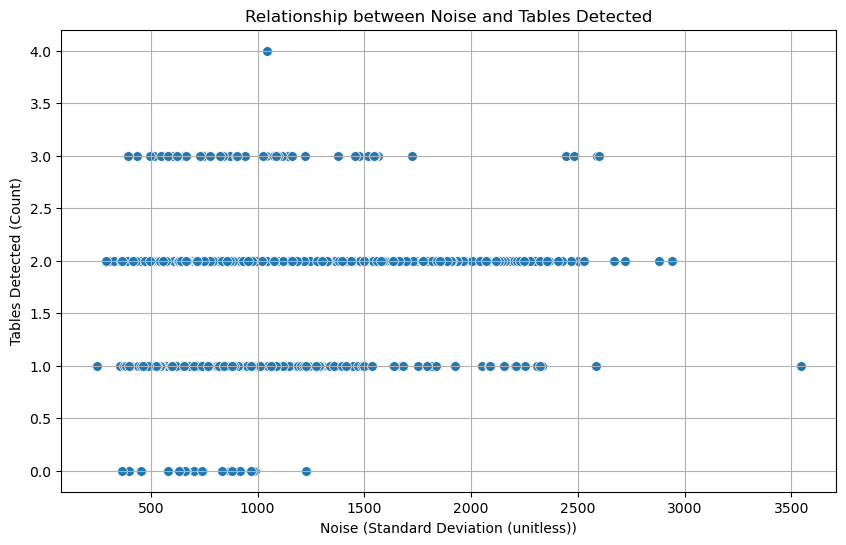

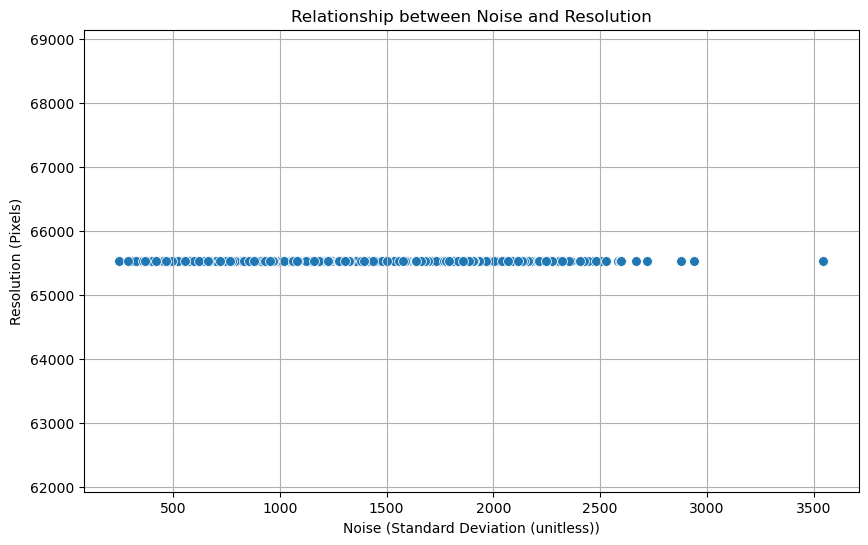

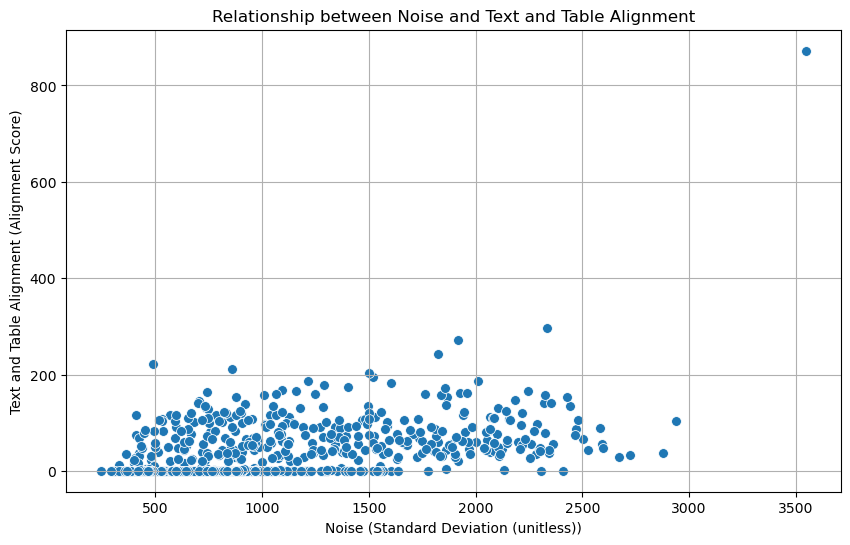

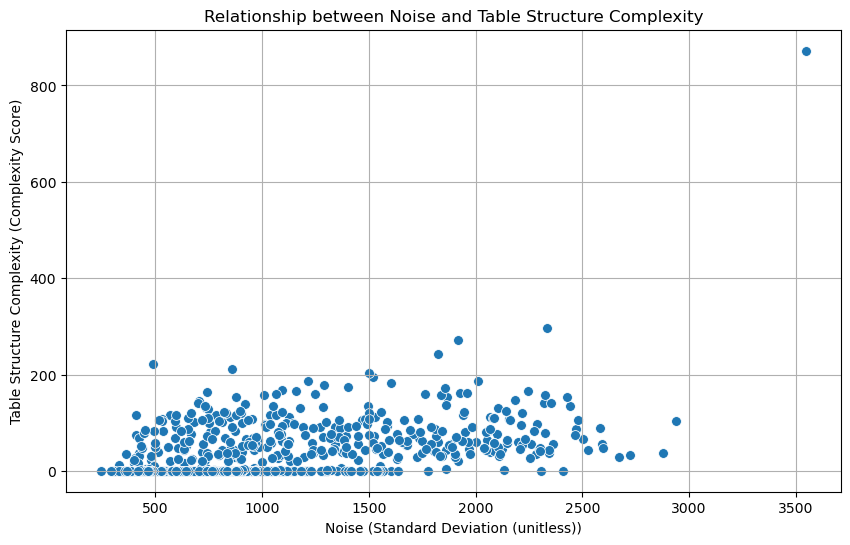

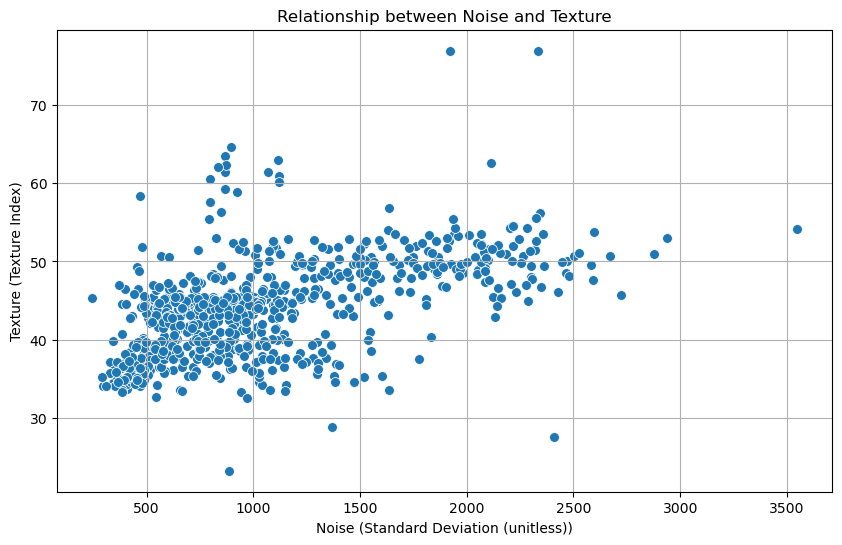

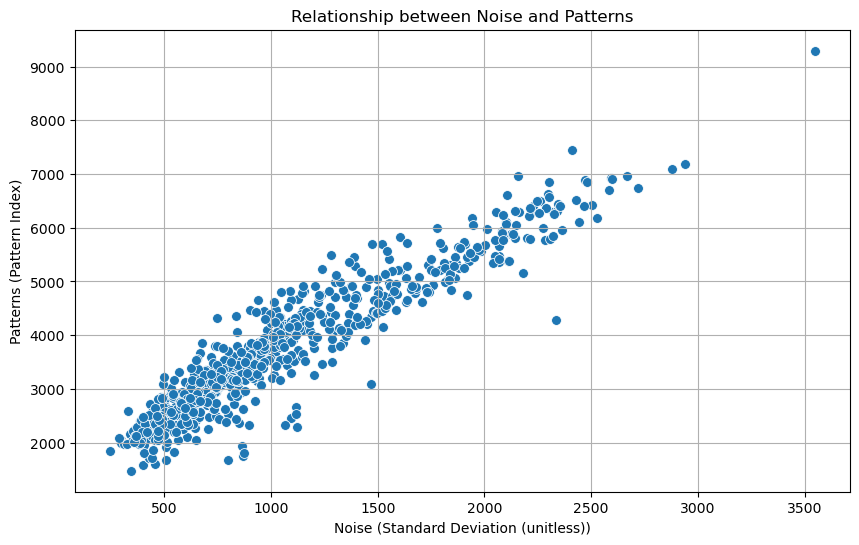

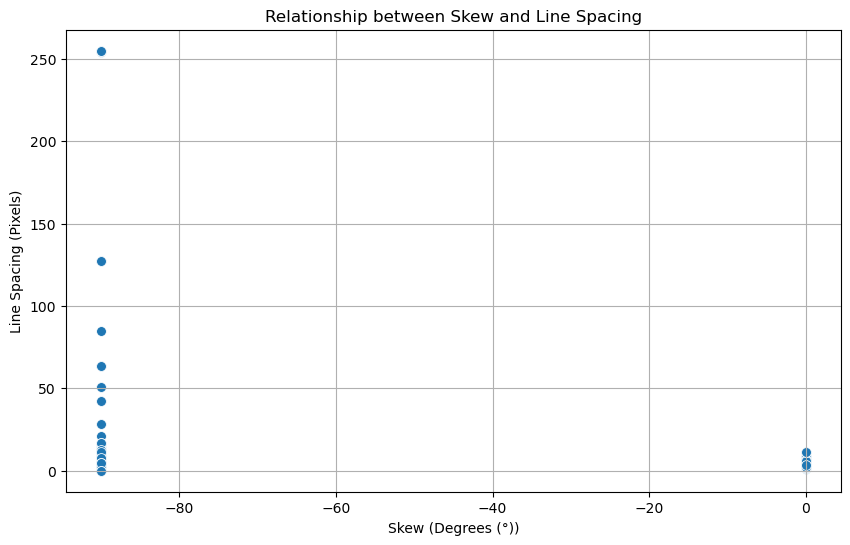

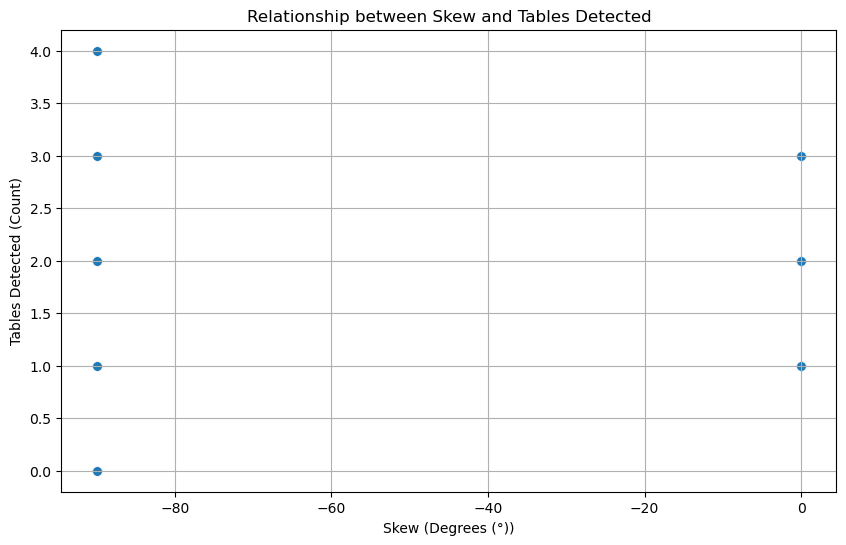

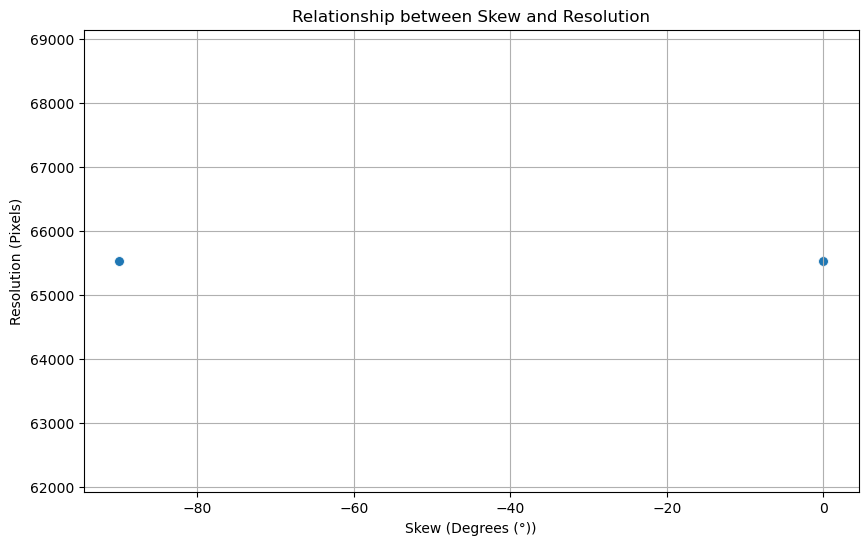

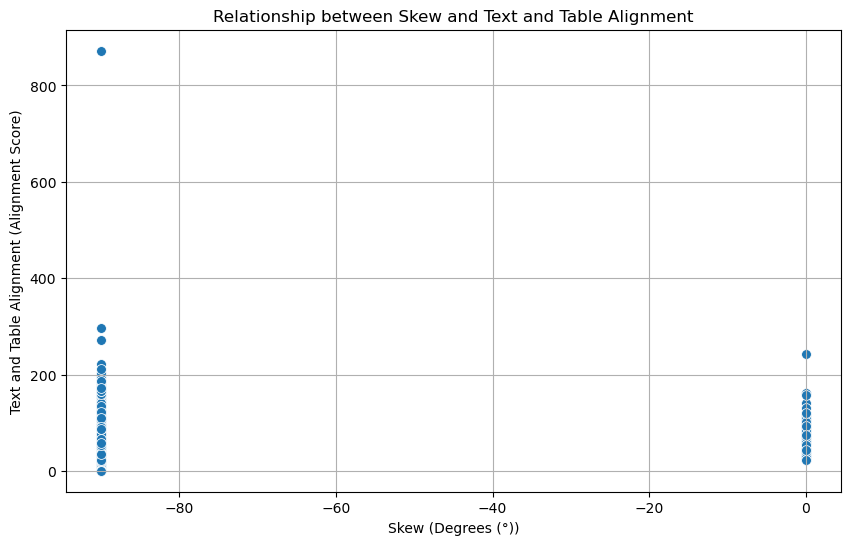

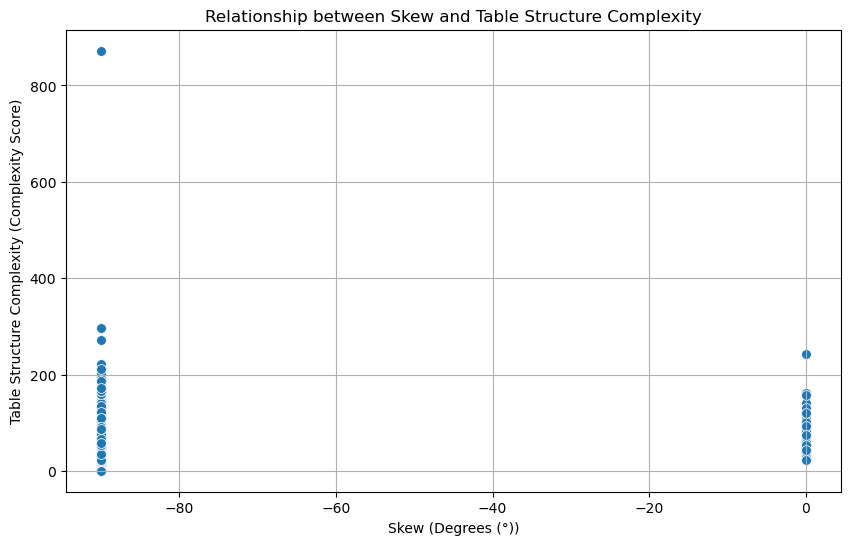

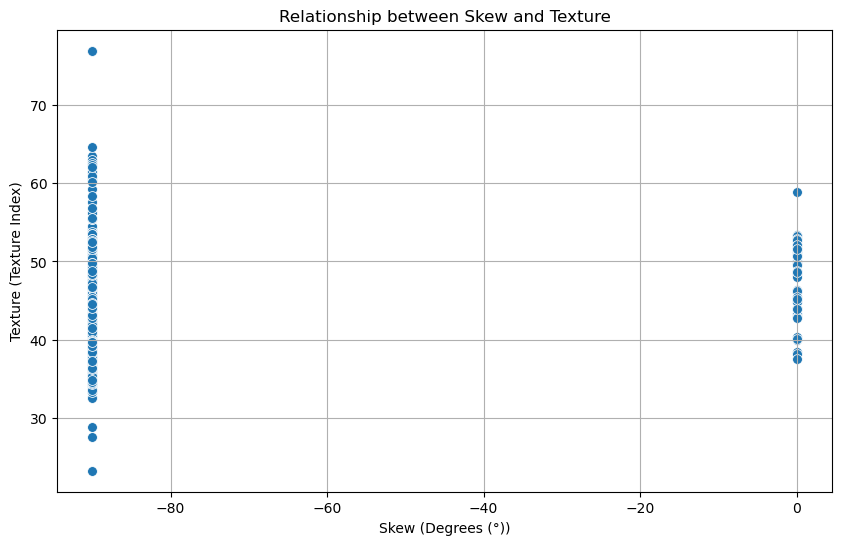

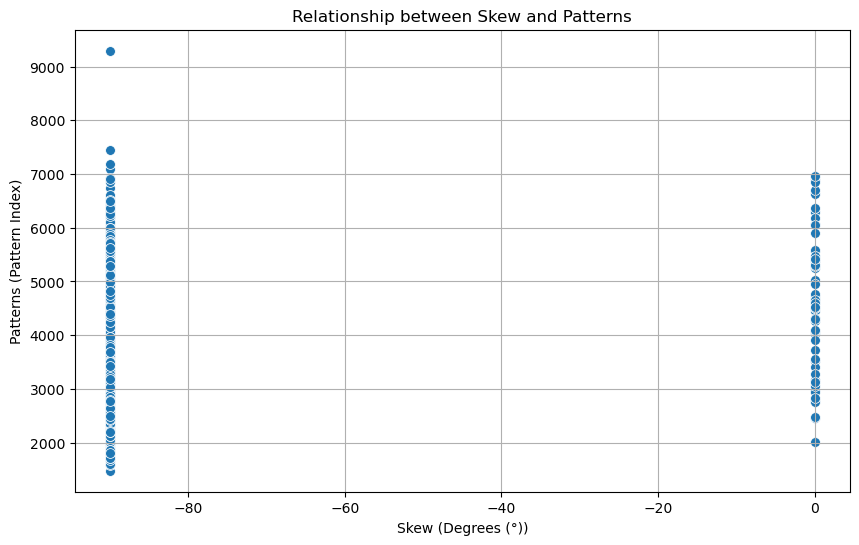

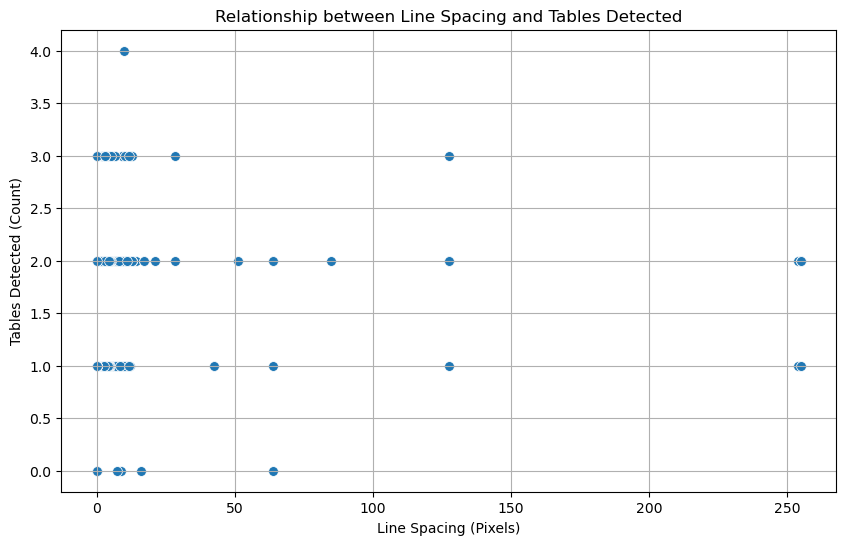

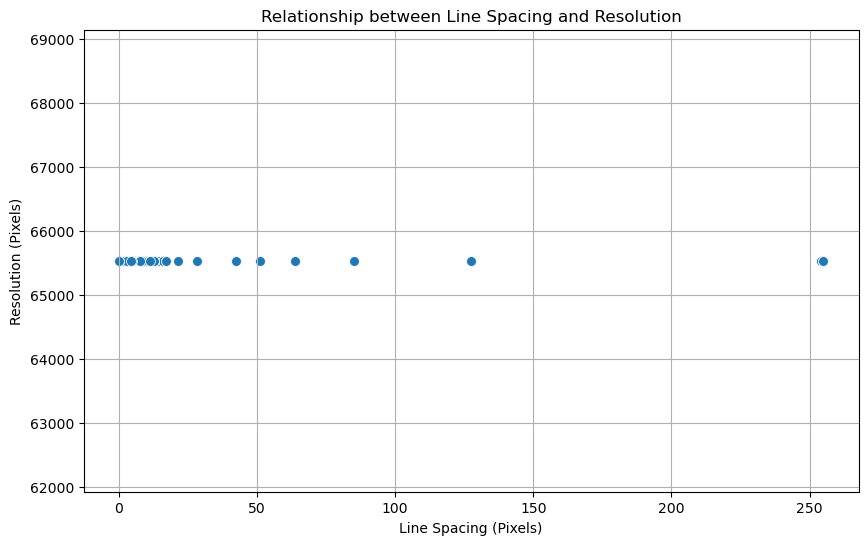

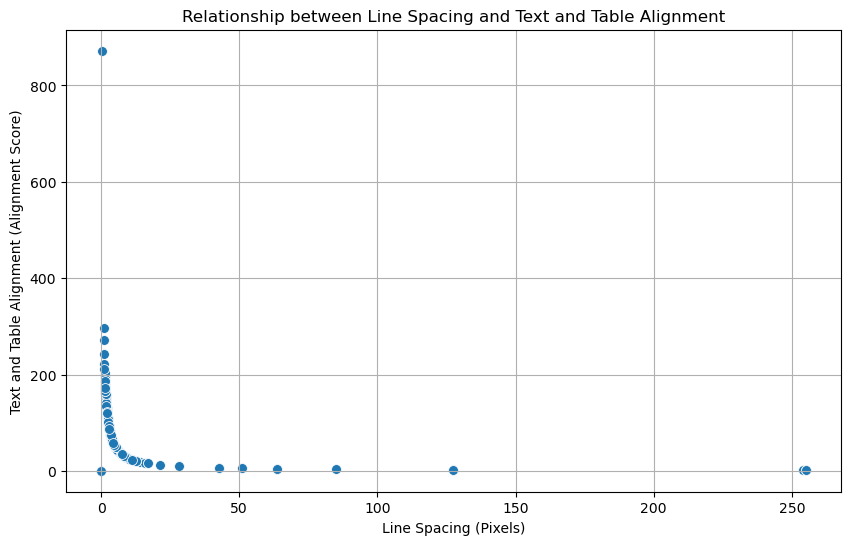

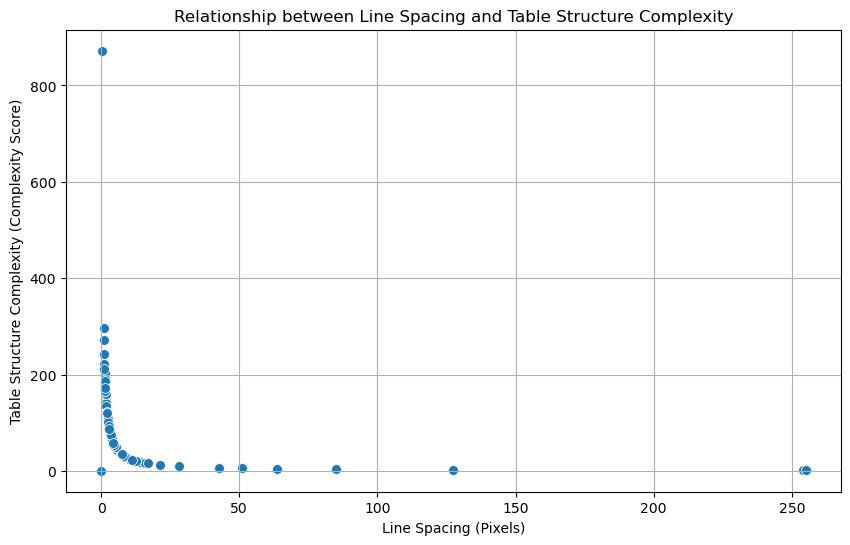

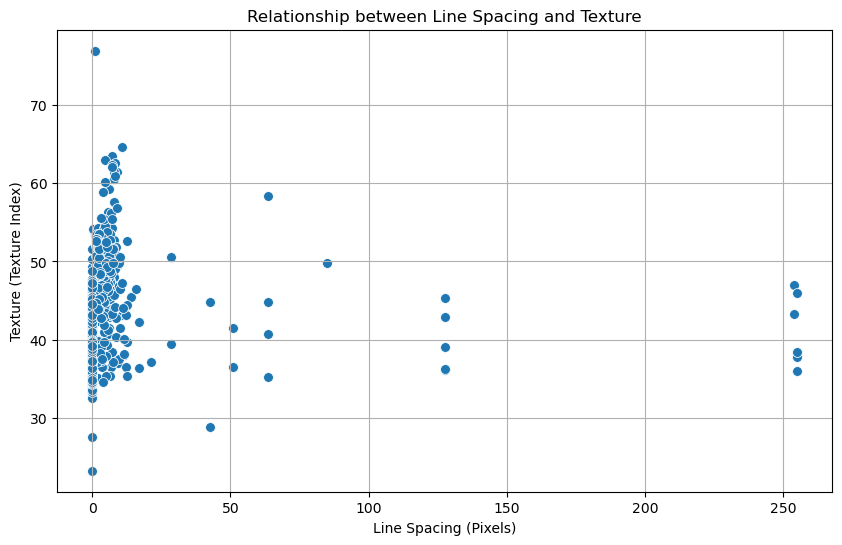

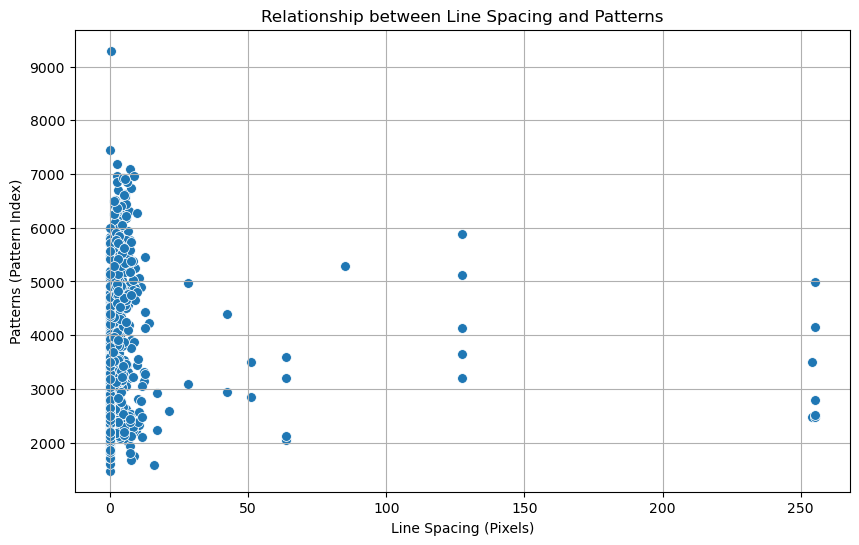

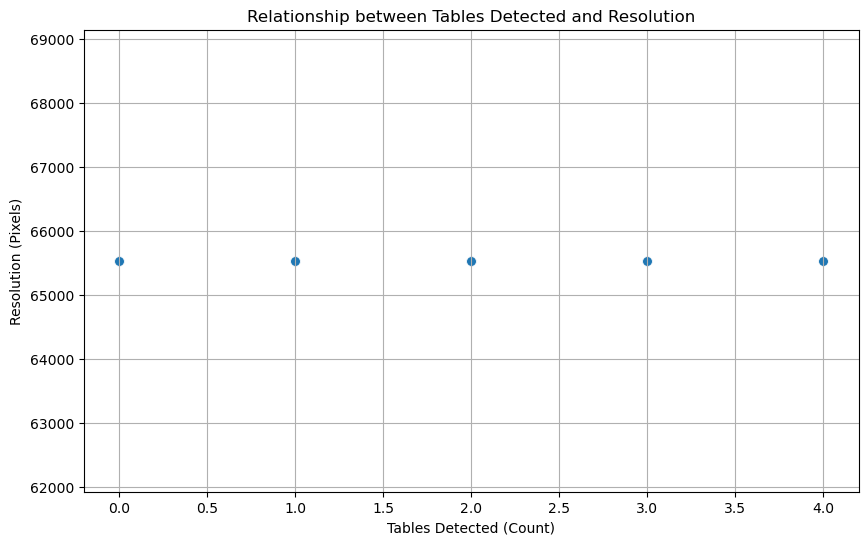

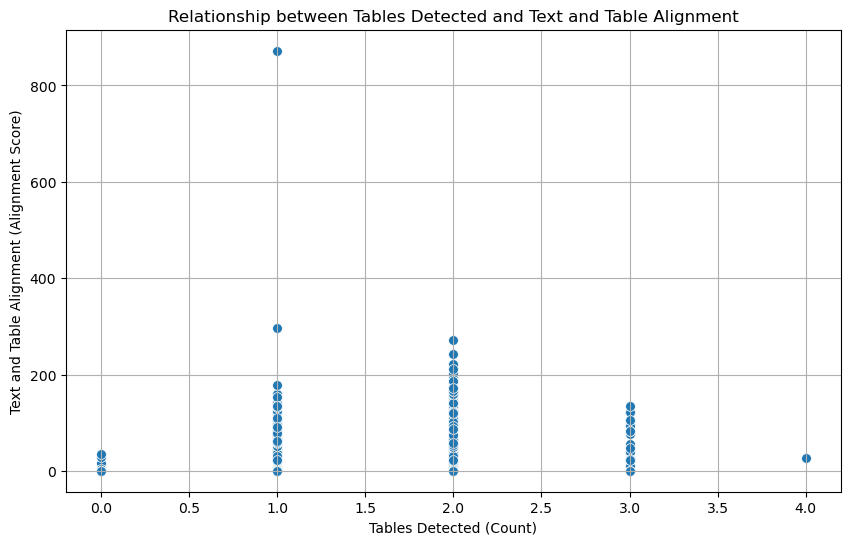

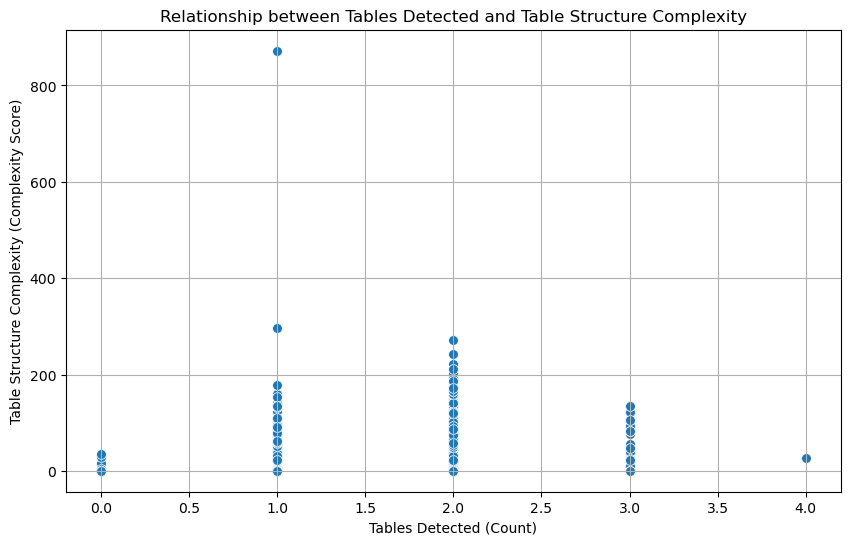

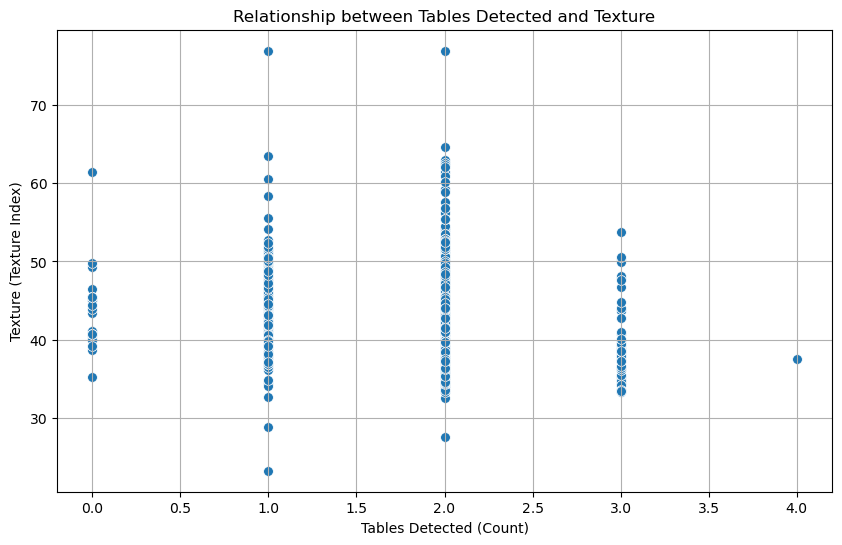

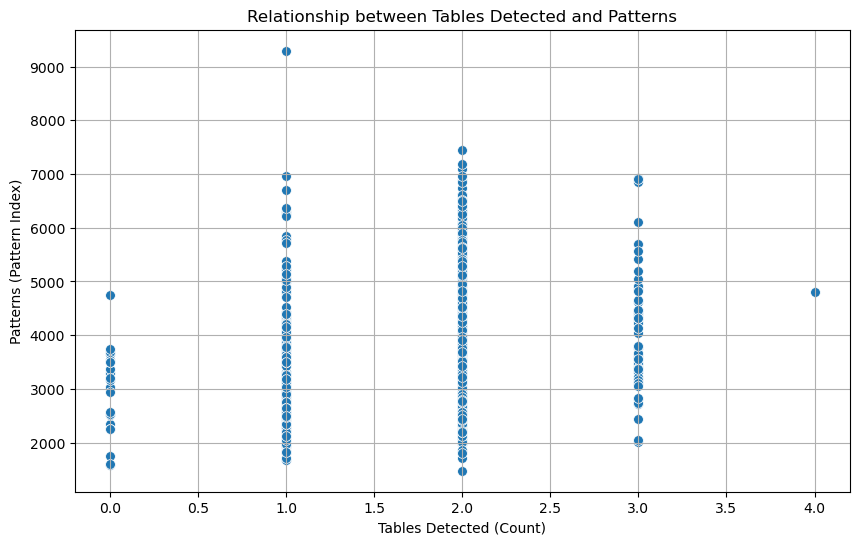

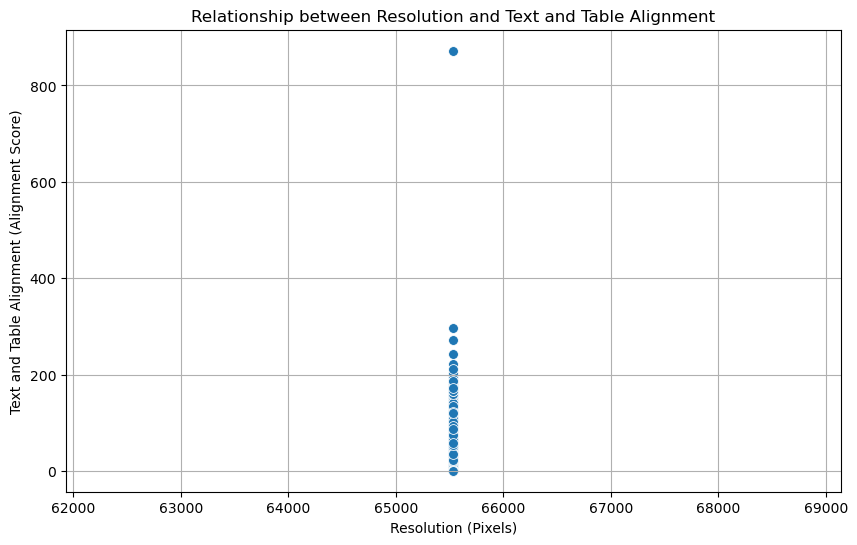

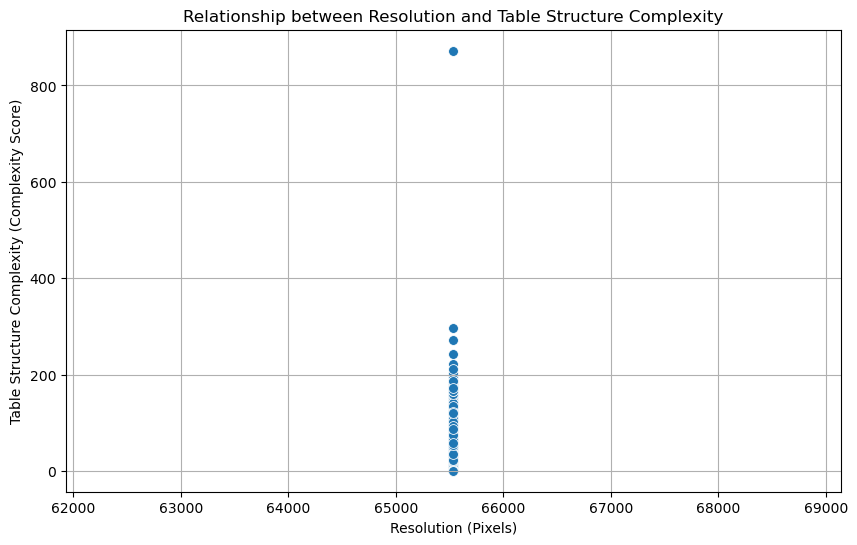

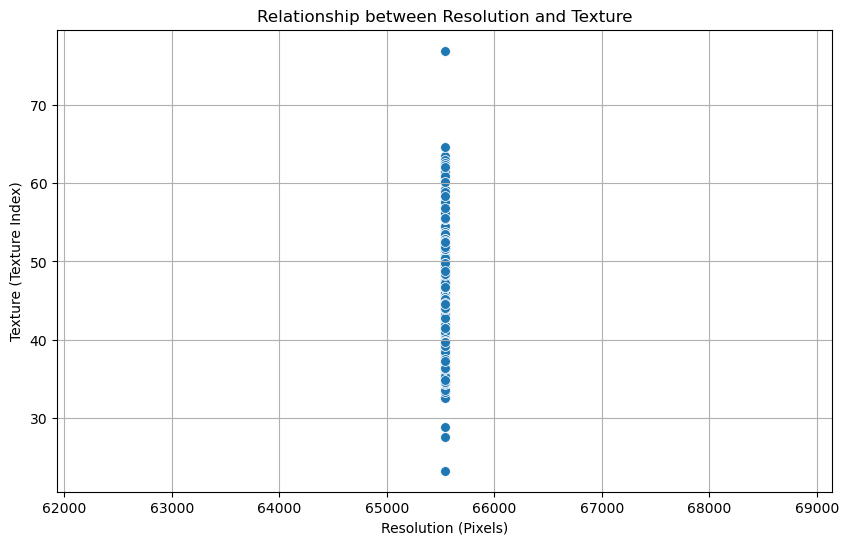

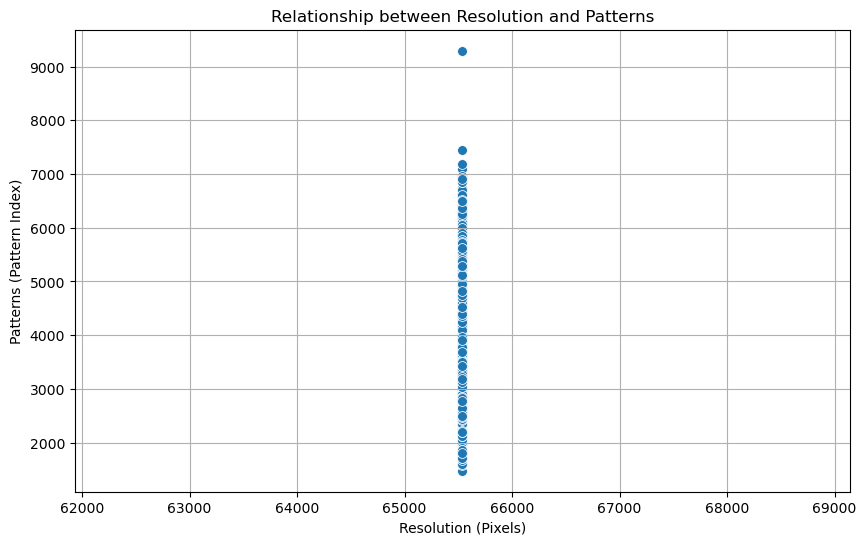

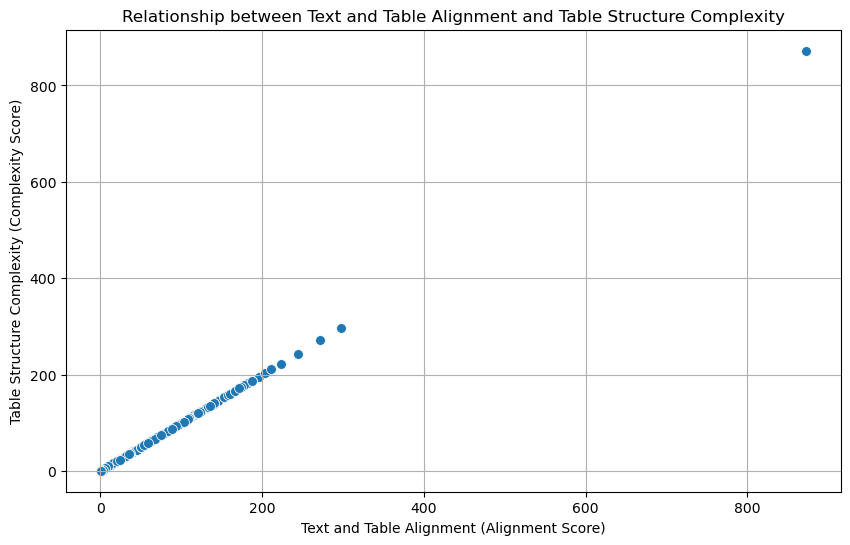

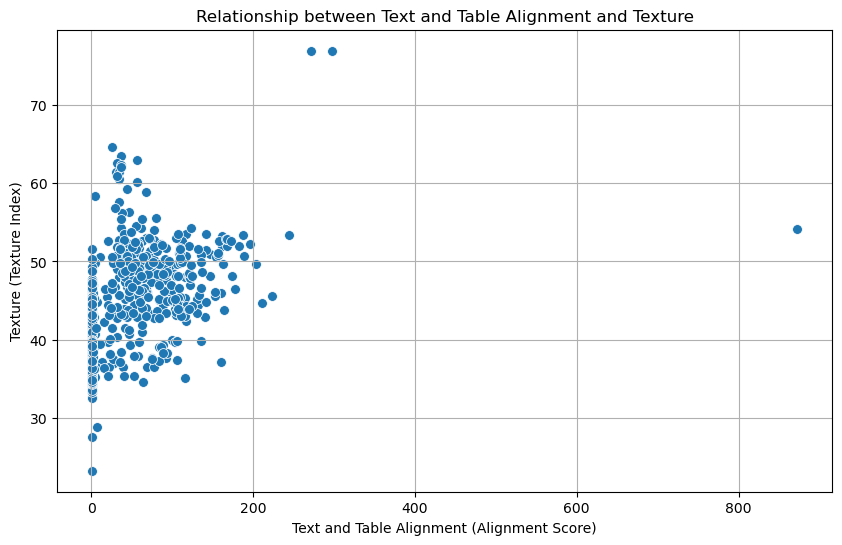

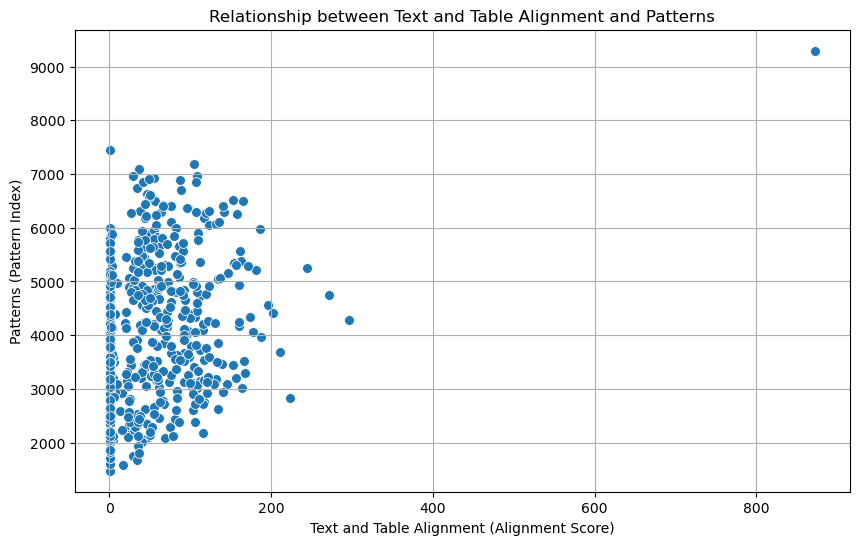

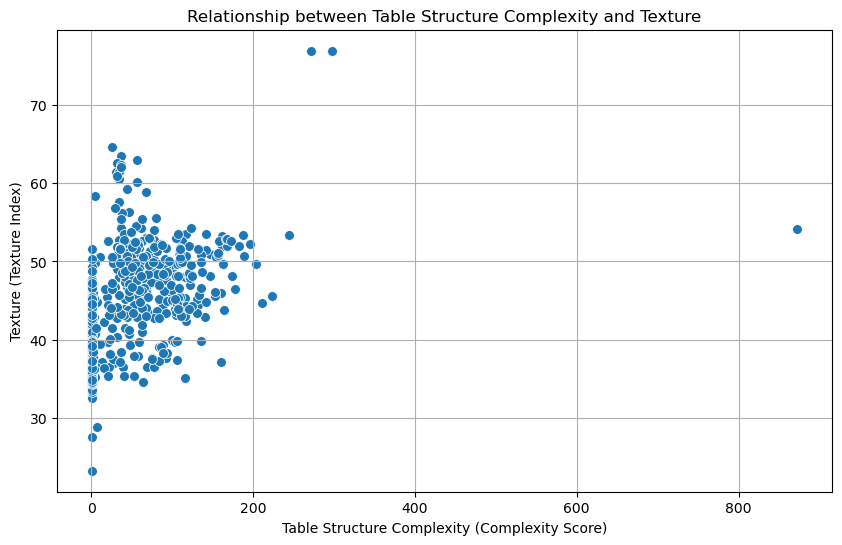

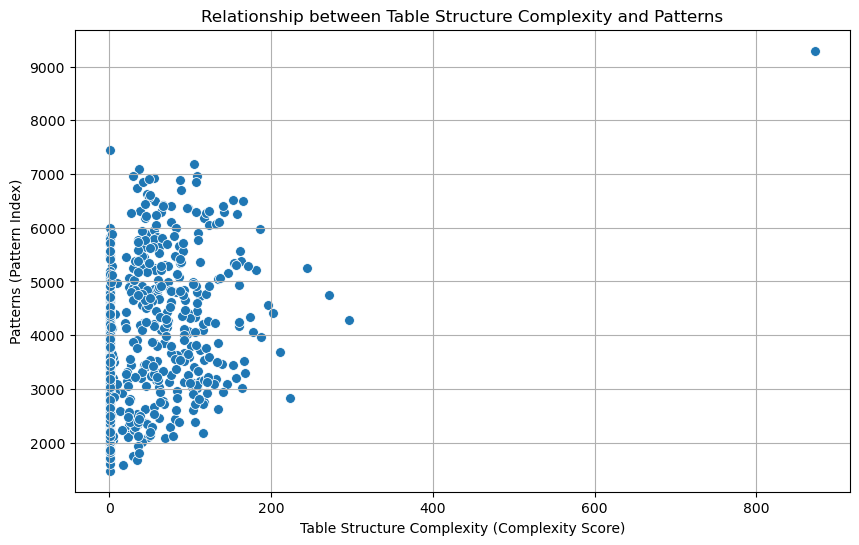

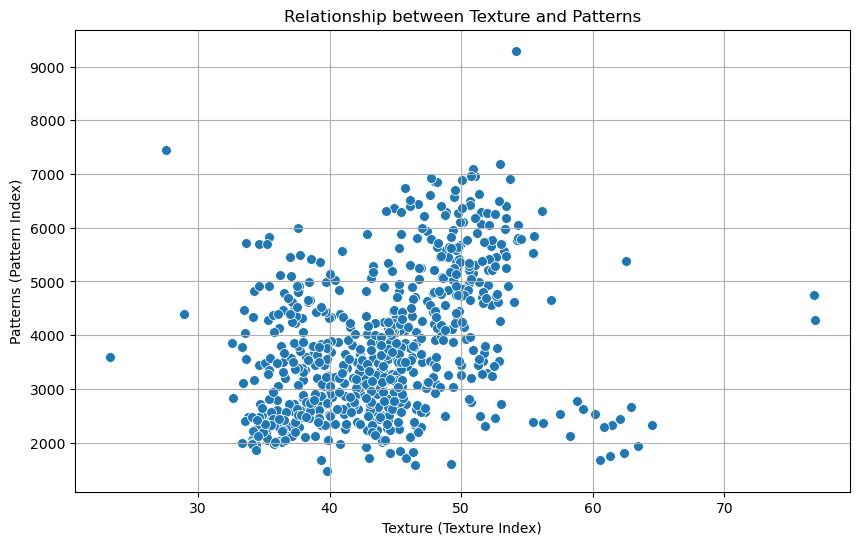

In [33]:
# Generate pairs of characteristics
pairs = itertools.combinations(characteristics_units.keys(), 2)

# Loop through each pair and create the relationship plots
for char1, char2 in pairs:
    plot_characteristic_relationship(
        df_stats,
        char1,
        char2,
        characteristics_units[char1],  # Get the unit for char1
        characteristics_units[char2]   # Get the unit for char2
    )

#### Heat Map

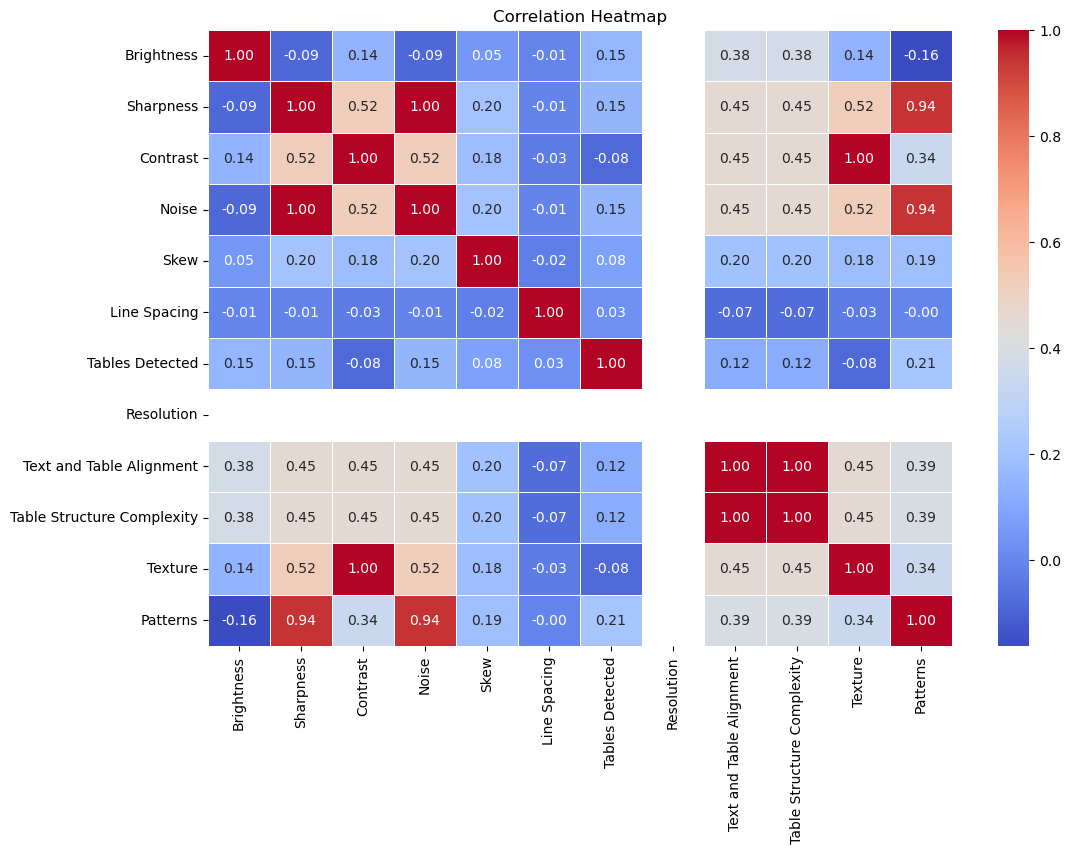

In [34]:
correlation_matrix = df_stats.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Step 6: Perform statistical tests

In [35]:
test_results_table = overall_statistical_tests(df_stats)
test_results_table

/var/folders/64/vcvwvzp5543c3rp1dpj_9k0c0000gn/T/ipykernel_8890/3914666176.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_stat, corr_p_val = stats.pearsonr(df[char1], df[char2])


Test            Characteristic_1 Characteristic_2  \
0             Normality                  Brightness             None   
1             Normality                   Sharpness             None   
2             Normality                    Contrast             None   
3   Pearson Correlation                  Brightness        Sharpness   
4   Pearson Correlation                  Brightness         Contrast   
..                  ...                         ...              ...   
64  Pearson Correlation    Text and Table Alignment          Texture   
65  Pearson Correlation    Text and Table Alignment         Patterns   
66  Pearson Correlation  Table Structure Complexity          Texture   
67  Pearson Correlation  Table Structure Complexity         Patterns   
68  Pearson Correlation                     Texture         Patterns   

     Statistic        P-Value  
0   512.223256  5.917432e-112  
1    94.519307   2.988087e-21  
2    72.774737   1.574587e-16  
3    -0.086529   2.223914e-02  
4     0.143239   1.463776e-04  
..         ...            ...  
64    0.454411   7.328078e-37  
65    0.393658   2.717715e-27  
66    0.454411   7.328078e-37  
67    0.393658   2.717715e-27  
68    0.338710   3.383227e-20  

[69 rows x 5 columns]